In [1]:
import numpy as np
import pandas as pd
import os
import re
import rdkit.Chem.AllChem as Chem
import rdkit.Chem.Draw as Draw
from graph_attribution.datasets import save_graphtuples, load_graphstuples
from rdkit.Chem.Draw import SimilarityMaps
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import rdkit.Chem.AllChem as Chem
from rdkit import DataStructs
import json
import pandas as pd
import numpy as np
from graphdot.model.gaussian_process import GaussianProcessRegressor as GPR
from mgktools.data.data import Dataset
from mgktools.kernels.utils import get_kernel_config
from mgktools.interpret.interpret import interpret_training_mols, interpret_atoms
from mgktools.hyperparameters import *
from mgktools.hyperparameters.hyperopt import bayesian_optimization
from mgktools.evaluators.cross_validation import Evaluator
from mgktools.features_mol.features_generators import FeaturesGenerator
from sklearn.metrics import mean_squared_error
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from IPython.display import display

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

2022-11-29 14:09:59.397217: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 14:09:59.952418: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/xiangyan/workspace/apps/cuda/11.6/lib64:
2022-11-29 14:09:59.952467: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/xiangyan/workspace/apps/cuda/11.6/lib64:
2022-11-29 14:09:59.952471: W tensor

rdkit detected? True


# Atomic Attribution

# Figure 1

In [2]:
df = pd.read_csv('../results/figure_data/hyperopt.csv')
df

dataset  n_subsets  auc_pred   auc_att  seed
0     logic7          1   0.98948  0.904723     0
1     logic7          1   0.98919  0.847454     1
2     logic7          1   0.99113  0.738418     2
3     logic7          1   0.98817  0.911576     3
4     logic7          1   0.99036  0.876132     4
..       ...        ...       ...       ...   ...
305  benzene        200   0.99990  0.998295     5
306  benzene        200   0.99994  0.995585     6
307  benzene        200   0.99993  0.997830     7
308  benzene        200   0.99999  0.997284     8
309  benzene        200   0.99999  0.996484     9

[310 rows x 5 columns]

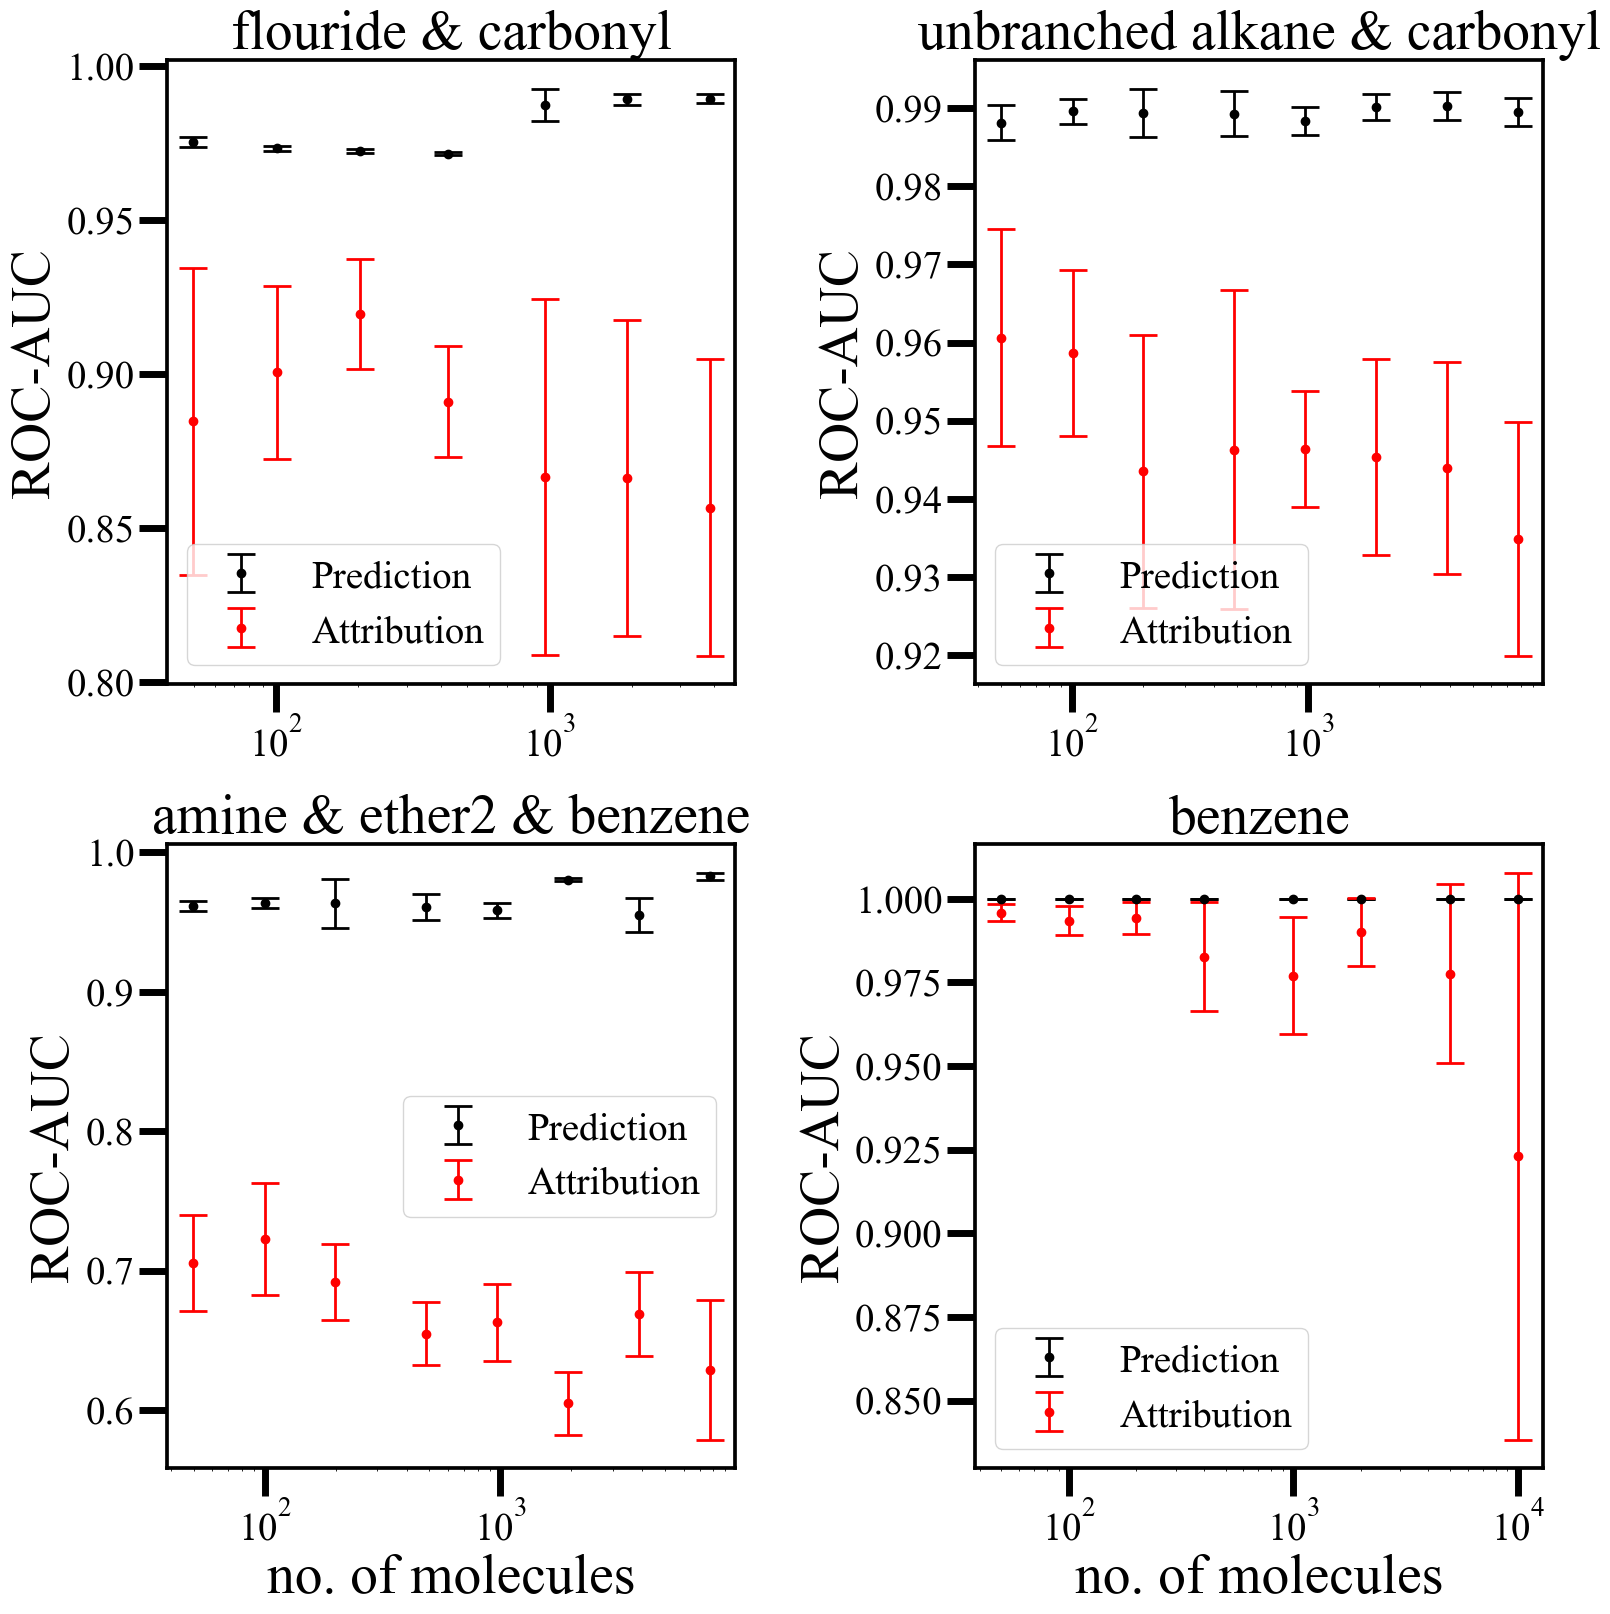

In [3]:
fs = 8
params = {'legend.fontsize': '%s' % (3.5 * fs),
          'figure.figsize': (fs * 2, fs * 2),  # 8*6
          'axes.labelsize': '%s' % (5 * fs),
          'axes.titlesize': '%s' % (5 * fs),
          'xtick.labelsize': '%s' % (3.5 * fs),
          'ytick.labelsize': '%s' % (3.5 * fs),
          'font.family': 'serif',
          'font.serif': 'Times New Roman',
          'axes.linewidth': fs / 3,
          }
pylab.rcParams.update(params)
fig = plt.figure()
fig.tight_layout()

dxs = [0.10, 0.15, 0.04]  # left to right
dx = (1 - sum(dxs)) / (len(dxs) - 1)
dys = [0.08, 0.1, 0.04]  # down to top
dy = (1 - sum(dys)) / (len(dys) - 1)

df = pd.read_csv('../results/figure_data/hyperopt.csv')

nx = 1
ny = 2
ax = fig.add_axes(
    [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
ax.tick_params(width=5, length=20)
dataset = 'logic7'
df1 = df[df.dataset == dataset]
n_subsets = df1.n_subsets.unique()
split_sizes = [3840 / n for n in n_subsets]
pred_auc = []
pred_auc_u = []
att_auc = []
att_auc_u = []
for i, n_subset in enumerate(n_subsets):
    pred= df1[df1.n_subsets == n_subset]['auc_pred'].tolist()
    att= df1[df1.n_subsets == n_subset]['auc_att'].tolist()
    pred_auc.append(np.mean(pred))
    pred_auc_u.append(np.std(pred))
    att_auc.append(np.mean(att))
    att_auc_u.append(np.std(att))
ax.errorbar(split_sizes, pred_auc, yerr=pred_auc_u, elinewidth=2, capsize=10, capthick=2, c='k', fmt='o', label='Prediction')
ax.set_ylabel('ROC-AUC')
ax.errorbar(split_sizes, att_auc, yerr=att_auc_u, elinewidth=2, capsize=10, capthick=2, c='red', fmt='o', label='Attribution')
ax.legend()

ax.set_xscale('log')
ax.set_title('flouride & carbonyl')

nx = 2
ny = 2
ax = fig.add_axes(
    [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
ax.tick_params(width=5, length=20)
dataset = 'logic8'
df1 = df[df.dataset == dataset]
n_subsets = df1.n_subsets.unique()
split_sizes = [7753 / n for n in n_subsets]
pred_auc = []
pred_auc_u = []
att_auc = []
att_auc_u = []
for i, n_subset in enumerate(n_subsets):
    pred= df1[df1.n_subsets == n_subset]['auc_pred'].tolist()
    att= df1[df1.n_subsets == n_subset]['auc_att'].tolist()
    pred_auc.append(np.mean(pred))
    pred_auc_u.append(np.std(pred))
    att_auc.append(np.mean(att))
    att_auc_u.append(np.std(att))
ax.errorbar(split_sizes, pred_auc, yerr=pred_auc_u, elinewidth=2, capsize=10, capthick=2, c='k', fmt='o', label='Prediction')
ax.set_ylabel('ROC-AUC')
ax.errorbar(split_sizes, att_auc, yerr=att_auc_u, elinewidth=2, capsize=10, capthick=2, c='red', fmt='o', label='Attribution')
ax.legend()

ax.set_xscale('log')
ax.set_title('unbranched alkane & carbonyl')

nx = 1
ny = 1
ax = fig.add_axes(
    [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
ax.tick_params(width=5, length=20)
dataset = 'logic10'
df1 = df[df.dataset == dataset]
n_subsets = df1.n_subsets.unique()
split_sizes = [7718 / n for n in n_subsets]
pred_auc = []
pred_auc_u = []
att_auc = []
att_auc_u = []
for i, n_subset in enumerate(n_subsets):
    pred= df1[df1.n_subsets == n_subset]['auc_pred'].tolist()
    att= df1[df1.n_subsets == n_subset]['auc_att'].tolist()
    pred_auc.append(np.mean(pred))
    pred_auc_u.append(np.std(pred))
    att_auc.append(np.mean(att))
    att_auc_u.append(np.std(att))
ax.errorbar(split_sizes, pred_auc, yerr=pred_auc_u, elinewidth=2, capsize=10, capthick=2, c='k', fmt='o', label='Prediction')
ax.set_ylabel('ROC-AUC')
ax.errorbar(split_sizes, att_auc, yerr=att_auc_u, elinewidth=2, capsize=10, capthick=2, c='red', fmt='o', label='Attribution')
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('no. of molecules')
ax.set_title('amine & ether2 & benzene')

nx = 2
ny = 1
ax = fig.add_axes(
    [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
ax.tick_params(width=5, length=20)
dataset = 'benzene'
df1 = df[df.dataset == dataset]
n_subsets = df1.n_subsets.unique()
split_sizes = [10000 / n for n in n_subsets]
pred_auc = []
pred_auc_u = []
att_auc = []
att_auc_u = []
for i, n_subset in enumerate(n_subsets):
    pred= df1[df1.n_subsets == n_subset]['auc_pred'].tolist()
    att= df1[df1.n_subsets == n_subset]['auc_att'].tolist()
    pred_auc.append(np.mean(pred))
    pred_auc_u.append(np.std(pred))
    att_auc.append(np.mean(att))
    att_auc_u.append(np.std(att))
ax.errorbar(split_sizes, pred_auc, yerr=pred_auc_u, elinewidth=2, capsize=10, capthick=2, c='k', fmt='o', label='Prediction')
ax.set_ylabel('ROC-AUC')
ax.errorbar(split_sizes, att_auc, yerr=att_auc_u, elinewidth=2, capsize=10, capthick=2, c='red', fmt='o', label='Attribution')
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('no. of molecules')
ax.set_title(dataset)

plt.savefig('figure1.png')

# Figure 2

smiles: CC(=C)C[NH2+]C[C@]1(CCCN(C1=O)Cc1cccc(c1F)F)O
ZINC: ZINC11999481
0.81707495
0.883134
smiles: C[C@@H](c1ccc2cc(ccc2c1)OC)C(=O)Nc1ccc(cn1)Br
ZINC: ZINC72003911
0.88207996
0.758253


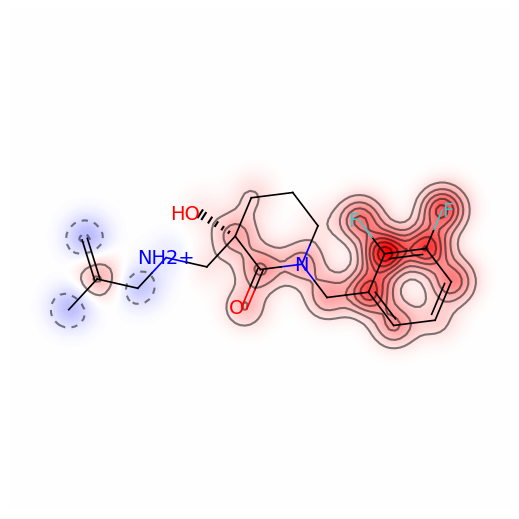

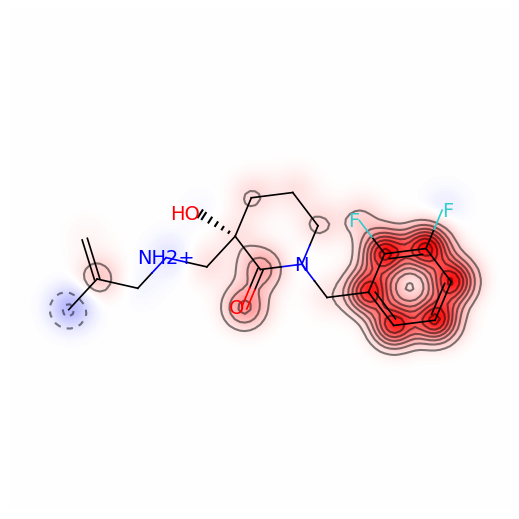

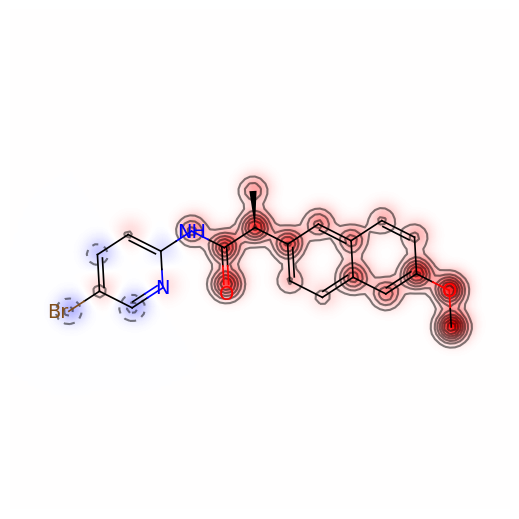

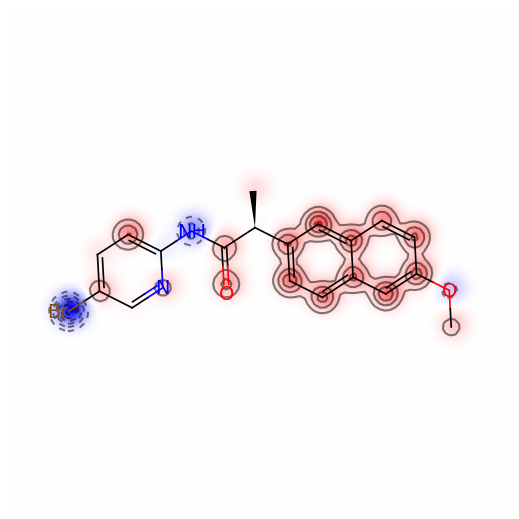

In [4]:
df_test = pd.read_csv('../results/raw_data/benzene/test.csv')

ids = [1, 100]
for i in ids:
    pred_att_npz = '../results/raw_data/benzene/hyperopt_loocv_1/9/mgk_attribution.npz'
    pred_atts = load_graphstuples(pred_att_npz)
    smiles = df_test.smiles[i]
    print('smiles: %s' % smiles)
    print('ZINC: %s' % df_test.mol_id[i])
    mol = Chem.MolFromSmiles(smiles)
    att = pred_atts[i].nodes.ravel()
    print(att.sum())
    for j, atom in enumerate(mol.GetAtoms()):
        atom.SetProp('atomNote', '%.6f' % att[j])
    SimilarityMaps.GetSimilarityMapFromWeights(mol, att, colorMap='bwr', contourLines=10, alpha=0.5, size=(200, 200))
    # Draw.MolToImage(mol, size=(800, 500))

    pred_att_npz = '../results/raw_data/benzene/hyperopt_loocv_100/0/mgk_attribution.npz'
    pred_atts = load_graphstuples(pred_att_npz)

    smiles = df_test.smiles[i]
    mol = Chem.MolFromSmiles(smiles)
    att = pred_atts[i].nodes.ravel()
    print(att.sum())
    for j, atom in enumerate(mol.GetAtoms()):
        atom.SetProp('atomNote', '%.6f' % att[j])
    SimilarityMaps.GetSimilarityMapFromWeights(mol, att, colorMap='bwr', contourLines=10, size=(200, 200))
    # Draw.MolToImage(mol, size=(500, 300))

# Molecular Attribution

In [5]:
# hyperparameter optimization
df = pd.read_csv('0_scaffold_order_train_size321.csv')
if not os.path.exists('hyperopt-graph/hyperparameters_0.json'):
    dataset = Dataset.from_df(df=df,
                              pure_columns=['smiles'],
                              target_columns=['freesolv'])
    dataset.graph_kernel_type = 'graph'
    kernel_config = get_kernel_config(dataset=dataset,
                                      graph_kernel_type='graph',
                                      mgk_hyperparameters_files=[additive_pnorm])
    best_hyperdict, results, hyperdicts = bayesian_optimization(save_dir='hyperopt-graph',
                                                                datasets=[dataset],
                                                                kernel_config=kernel_config,
                                                                model_type='gpr',
                                                                task_type='regression',
                                                                metric='rmse',
                                                                split_type='loocv',
                                                                num_iters=100,
                                                                alpha=0.01)

if not os.path.exists('hyperopt-morgan/features_hyperparameters.json'):
    dataset = Dataset.from_df(df=df,
                              pure_columns=['smiles'],
                              target_columns=['freesolv'],
                              features_generator=['morgan'])
    dataset.graph_kernel_type = None
    kernel_config = get_kernel_config(dataset=dataset,
                                      graph_kernel_type=None,
                                      features_kernel_type='rbf',
                                      features_hyperparameters=[1.0],
                                      features_hyperparameters_bounds=[(0.1, 10.0)],
                                      )
    best_hyperdict, results, hyperdicts = bayesian_optimization(save_dir='hyperopt-morgan',
                                                                datasets=[dataset],
                                                                kernel_config=kernel_config,
                                                                model_type='gpr',
                                                                task_type='regression',
                                                                metric='rmse',
                                                                split_type='loocv',
                                                                num_iters=100,
                                                                alpha=0.01)
# Prediction
df_test = pd.read_csv('0_scaffold_order_test_size321.csv')
train = Dataset.from_df(df=df, 
                        pure_columns=['smiles'], 
                        target_columns=['freesolv'])
train.graph_kernel_type = 'graph'
test = Dataset.from_df(df=df_test, 
                       pure_columns=['smiles'], 
                       target_columns=['freesolv'])
test.graph_kernel_type = 'graph'
kernel_config = get_kernel_config(dataset=train,
                                  graph_kernel_type='graph',
                                  mgk_hyperparameters_files=['hyperopt-graph/hyperparameters_0.json'])
gpr = GPR(kernel=kernel_config.kernel,
          optimizer=None,
          alpha=0.01,)
gpr.fit(train.X, train.y)
y_pred_mgk = gpr.predict(test.X)
# rmse(test.y, y_pred_mgk)

train = Dataset.from_df(df=df, 
                        pure_columns=['smiles'], 
                        target_columns=['freesolv'],
                       features_generator=['morgan'])
test = Dataset.from_df(df=df_test, 
                       pure_columns=['smiles'], 
                       target_columns=['freesolv'], features_generator=['morgan'])
kernel_config = get_kernel_config(dataset=train,
                                  graph_kernel_type=None,
                                  features_hyperparameters_file='hyperopt-morgan/features_hyperparameters.json'
                                  )
gpr = GPR(kernel=kernel_config.kernel,
          optimizer=None,
          alpha=0.01,)
gpr.fit(train.X, train.y)
y_pred_morgan = gpr.predict(test.X)
# rmse(test.y, y_pred_morgan)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 321 out of 321 | elapsed:    4.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 321 out of 321 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 321 out of 321 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 321 out of 321 | elapsed:    1.2s finished


# Figure 3

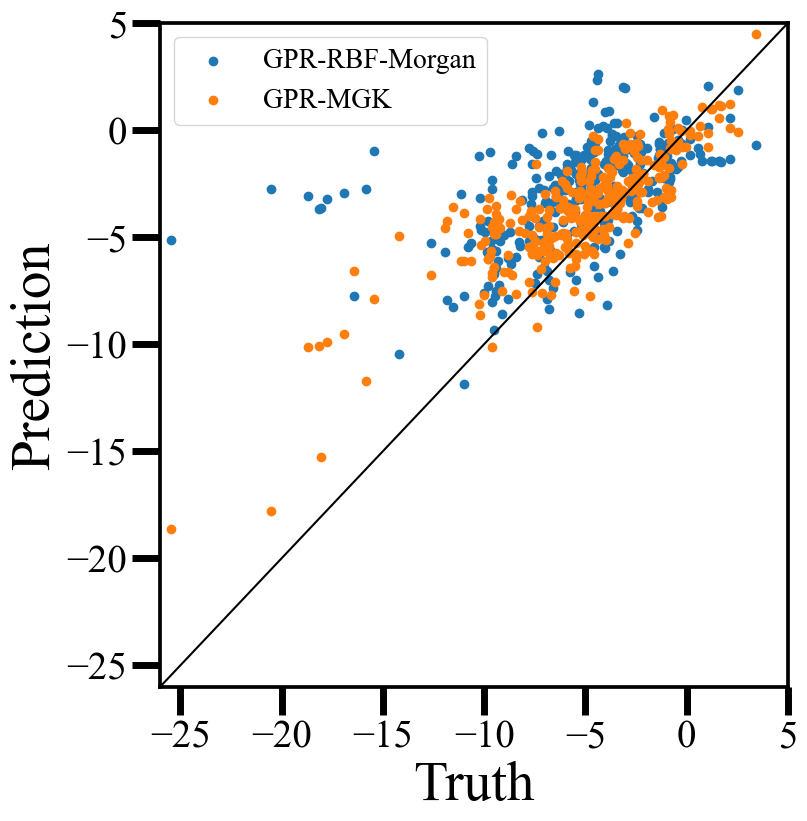

In [6]:
# fs = 8
params = {'legend.fontsize': '%s' % (2.5 * fs),
          'figure.figsize': (fs * 1, fs * 1),  # 8*6
          'axes.labelsize': '%s' % (5 * fs),
          'axes.titlesize': '%s' % (5 * fs),
          'xtick.labelsize': '%s' % (3.5 * fs),
          'ytick.labelsize': '%s' % (3.5 * fs),
          'font.family': 'serif',
          'font.serif': 'Times New Roman',
          'axes.linewidth': fs / 3,
          }
pylab.rcParams.update(params)
fig = plt.figure()
fig.tight_layout()

dxs = [0.20, 0.015]  # left to right
dx = (1 - sum(dxs)) / (len(dxs) - 1)
dys = [0.15, 0.02]  # down to top
dy = (1 - sum(dys)) / (len(dys) - 1)

nx = 1
ny = 1
ax = fig.add_axes(
    [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
ax.tick_params(width=5, length=20)

ax.scatter(test.y, y_pred_morgan, label='GPR-RBF-Morgan')
ax.scatter(test.y, y_pred_mgk, label='GPR-MGK')
ax.set_xlabel('Truth')
ax.set_ylabel('Prediction')
ax.plot([-30, 5], [-30, 5], 'k')
ax.legend()
ax.set_xlim([-26, 5])
ax.set_ylim([-26, 5])
ax.set_xticks(range(-25, 10, 5))

plt.savefig('figure3.png')

# Figures 4 and 5

In [7]:
df = pd.read_csv('0_scaffold_order_train_size321.csv')
smiles_list = df_test.sort_values('freesolv')[:5].smiles.tolist()
df_test.sort_values('freesolv')[:5]
smiles_train = df['smiles']
targets_train = df['freesolv']
alpha = 0.01
n_mol = 10000
for i, smiles in enumerate(smiles_list):
    mol = Chem.MolFromSmiles(smiles)
    Draw.MolToImageFile(mol, 'mol_%d.png' % i)

In [8]:
df_test.sort_values('freesolv')

smiles  freesolv
177  C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O    -25.47
103            C1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O    -20.52
102                        c1c(c(=O)[nH]c(=O)[nH]1)I    -18.72
37                        c1c(c(=O)[nH]c(=O)[nH]1)Br    -18.17
78                     c1(=O)[nH]c(=O)[nH]c(=O)[nH]1    -18.06
..                                               ...       ...
135                                        CC1CCCCC1      1.70
195                                     CC1CCC(CC1)C      2.11
273                                       CCCC1CCCC1      2.13
255                                     CCCCCC1CCCC1      2.55
265                     C1(C(C(C1(F)F)(F)F)(F)F)(F)F      3.43

[321 rows x 2 columns]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    1.0s finished


                                 smiles_train  contribution_percentage  \
0    C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O                 0.718377   
1                             c1ccc2c(c1)CCC2                 0.414054   
2                             CCCCOC[C@H](C)O                 0.210544   
3                                 CCC/C=C/C=O                -0.145774   
4                                    CC(C)CCO                -0.141179   
..                                        ...                      ...   
316                                  C=CCCC=C                -0.000249   
317                                       CCC                 0.000207   
318                                 CCCCCCCBr                -0.000130   
319                               CCCCCCCCCCO                 0.000100   
320                                  CCCCCCCI                 0.000015   

     contribution_value    kernel  
0            -16.968054  7.460976  
1             -0.604518  6.146553  
2  

/home/xiangyan/workspace/apps/miniconda3/envs/graph-attribution/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 12. Change the maxMols value to display more.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    0.5s finished


                                 smiles_train  contribution_percentage  \
0    C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O                 0.620277   
1                             c1ccc2c(c1)CCC2                 0.467635   
2                             CCCCOC[C@H](C)O                 0.329279   
3                                 CCC/C=C/C=O                -0.186255   
4                               CCCCC/C=C/C=O                -0.146150   
..                                        ...                      ...   
316                                     CCCCI                 0.000489   
317                                   CC(=O)C                -0.000399   
318                                       CSC                 0.000280   
319                         C(=C(Cl)Cl)(Cl)Cl                -0.000199   
320                                      CSSC                 0.000086   

     contribution_value    kernel  
0            -14.650943  7.297049  
1             -0.682748  6.140330  
2  

/home/xiangyan/workspace/apps/miniconda3/envs/graph-attribution/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 12. Change the maxMols value to display more.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.3s finished


               smiles_train  contribution_percentage  contribution_value  \
0           c1ccc2c(c1)CCC2                 0.714706           -1.043471   
1               COC(=O)CC#N                 0.448060           -3.010963   
2    CC(C)(/C=N\OC(=O)NC)SC                 0.375107           -3.691050   
3                 C/C=C/C=O                 0.179944           -0.759364   
4                  CC(=O)OC                -0.140211            0.438862   
..                      ...                      ...                 ...   
316          CCCCCCCCC(=O)C                -0.000442            0.001033   
317   C(C(F)(Cl)Cl)(F)(F)Cl                -0.000366           -0.000649   
318                      CC                 0.000322            0.000589   
319      CCCN(CCC)C(=O)SCCC                -0.000128            0.000528   
320         CC(C)C(=O)C(C)C                 0.000109           -0.000298   

       kernel  
0    6.172775  
1    5.553038  
2    5.596056  
3    5.480243  
4    5.

/home/xiangyan/workspace/apps/miniconda3/envs/graph-attribution/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 12. Change the maxMols value to display more.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.3s finished


               smiles_train  contribution_percentage  contribution_value  \
0           c1ccc2c(c1)CCC2                 0.714727           -1.043501   
1               COC(=O)CC#N                 0.446435           -3.000044   
2    CC(C)(/C=N\OC(=O)NC)SC                 0.371850           -3.659004   
3                 C/C=C/C=O                 0.180378           -0.761193   
4                  CC(=O)OC                -0.140679            0.440324   
..                      ...                      ...                 ...   
316             CCCCCC(=O)O                -0.000214            0.001329   
317                      CI                -0.000200            0.000178   
318             CC[C@H](C)O                -0.000077            0.000356   
319                      CC                 0.000074            0.000136   
320        CCOP(=O)(OCC)OCC                 0.000059           -0.000441   

       kernel  
0    6.172775  
1    5.553038  
2    5.596056  
3    5.480243  
4    5.

/home/xiangyan/workspace/apps/miniconda3/envs/graph-attribution/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 12. Change the maxMols value to display more.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    0.5s finished


               smiles_train  contribution_percentage  contribution_value  \
0               COC(=O)CC#N                 0.684472           -4.599652   
1           c1ccc2c(c1)CCC2                 0.666326           -0.972836   
2    CC(C)(/C=N\OC(=O)NC)SC                 0.408526           -4.019896   
3         CCOC(=O)CC(=O)OCC                 0.367120           -2.202719   
4                  CC(=O)NC                 0.309876           -3.098759   
..                      ...                      ...                 ...   
316                 C(Br)Br                 0.000602           -0.001179   
317                C(CBr)Cl                -0.000530            0.001033   
318            CC(=C)C(=C)C                -0.000518           -0.000207   
319                 CC(C)OC                -0.000512            0.001030   
320                      CI                 0.000141           -0.000125   

       kernel  
0    5.462559  
1    5.933036  
2    5.495733  
3    5.488137  
4    5.

/home/xiangyan/workspace/apps/miniconda3/envs/graph-attribution/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 12. Change the maxMols value to display more.
  warnings.warn(


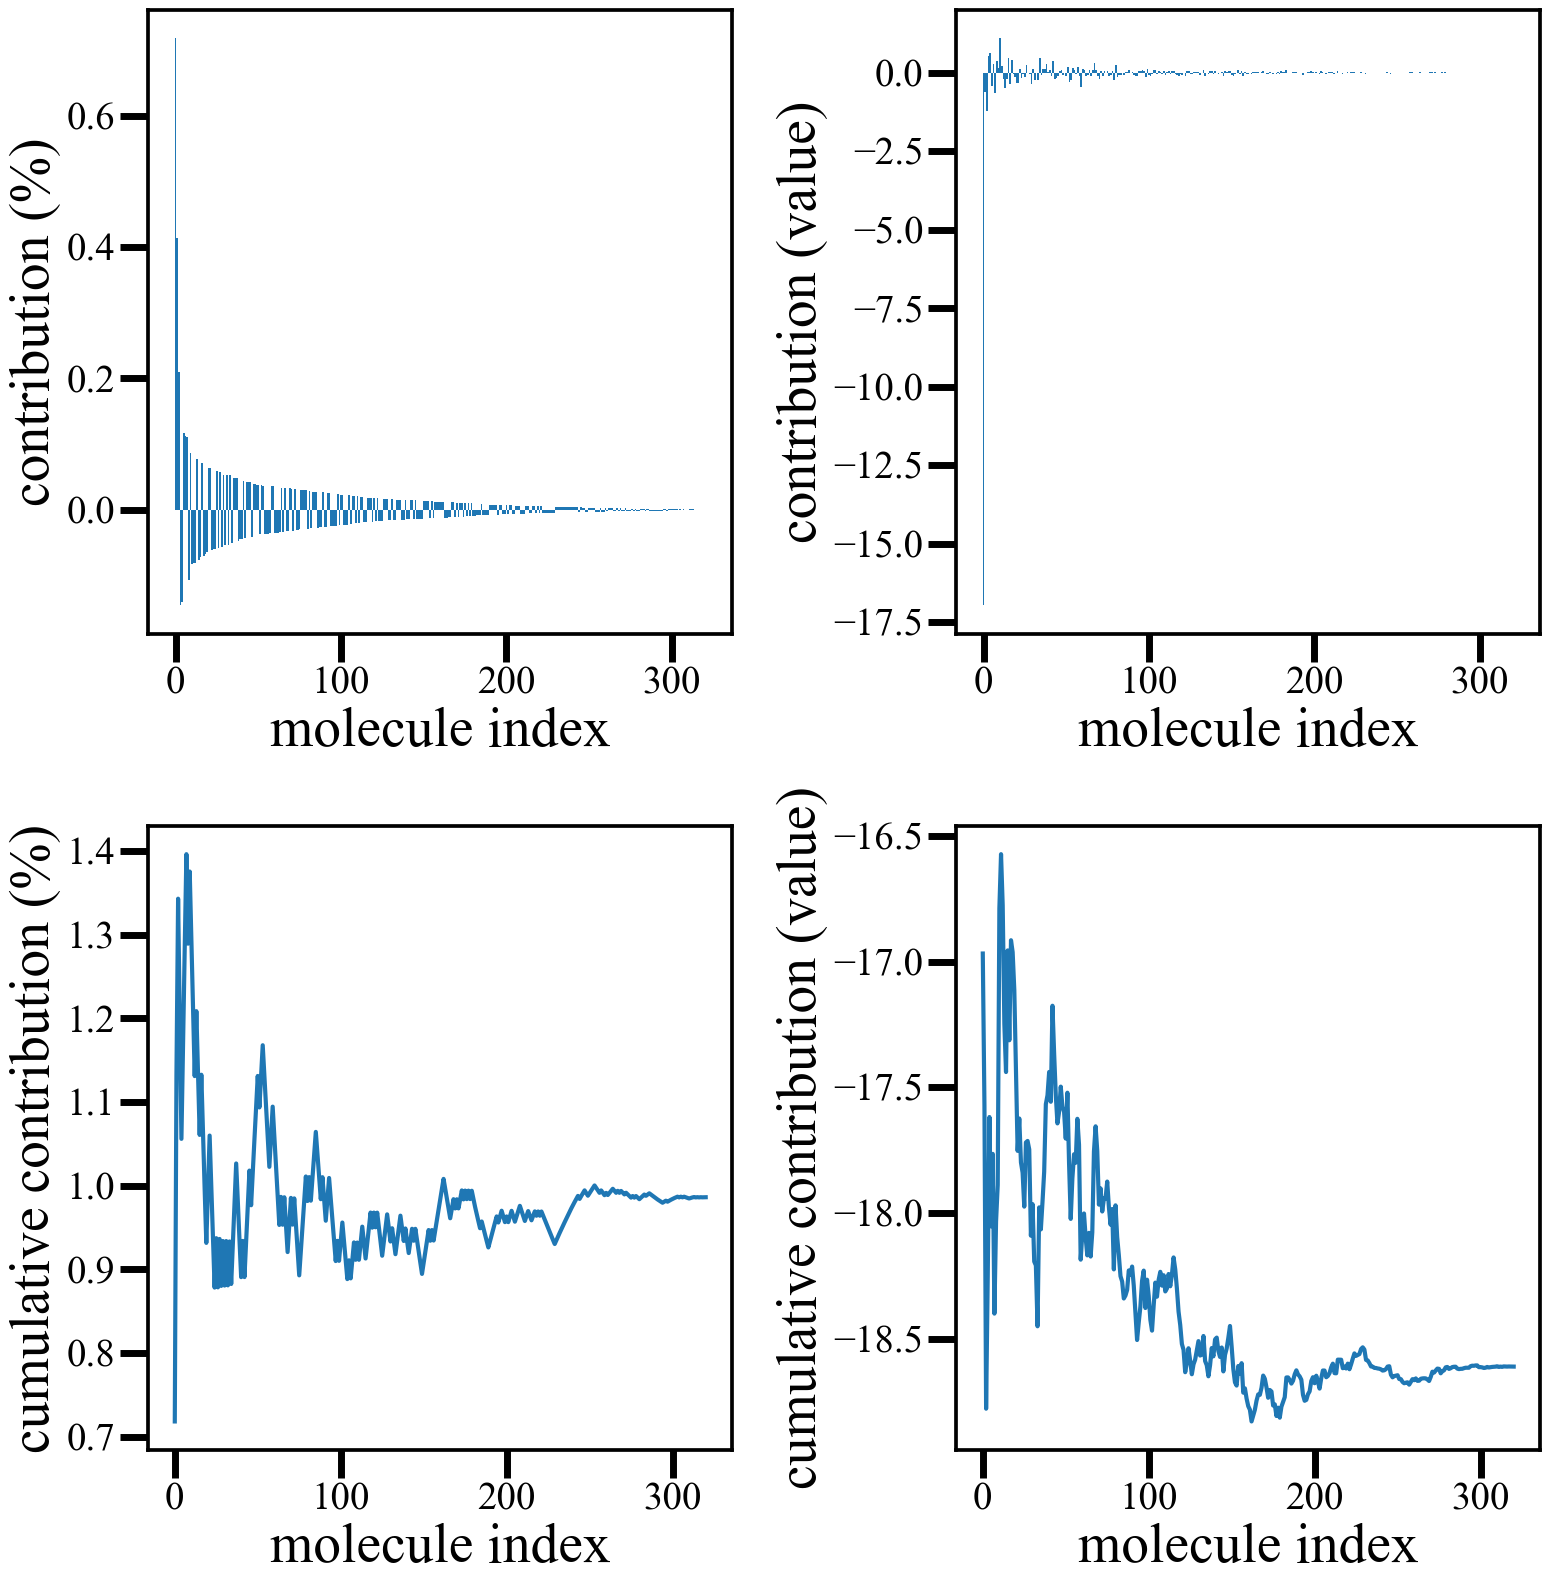

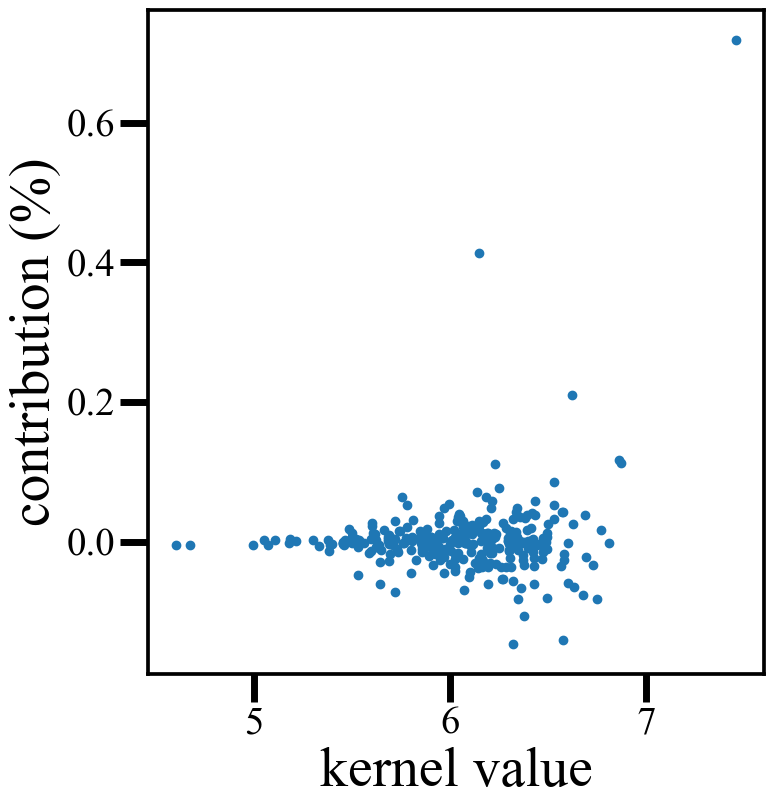

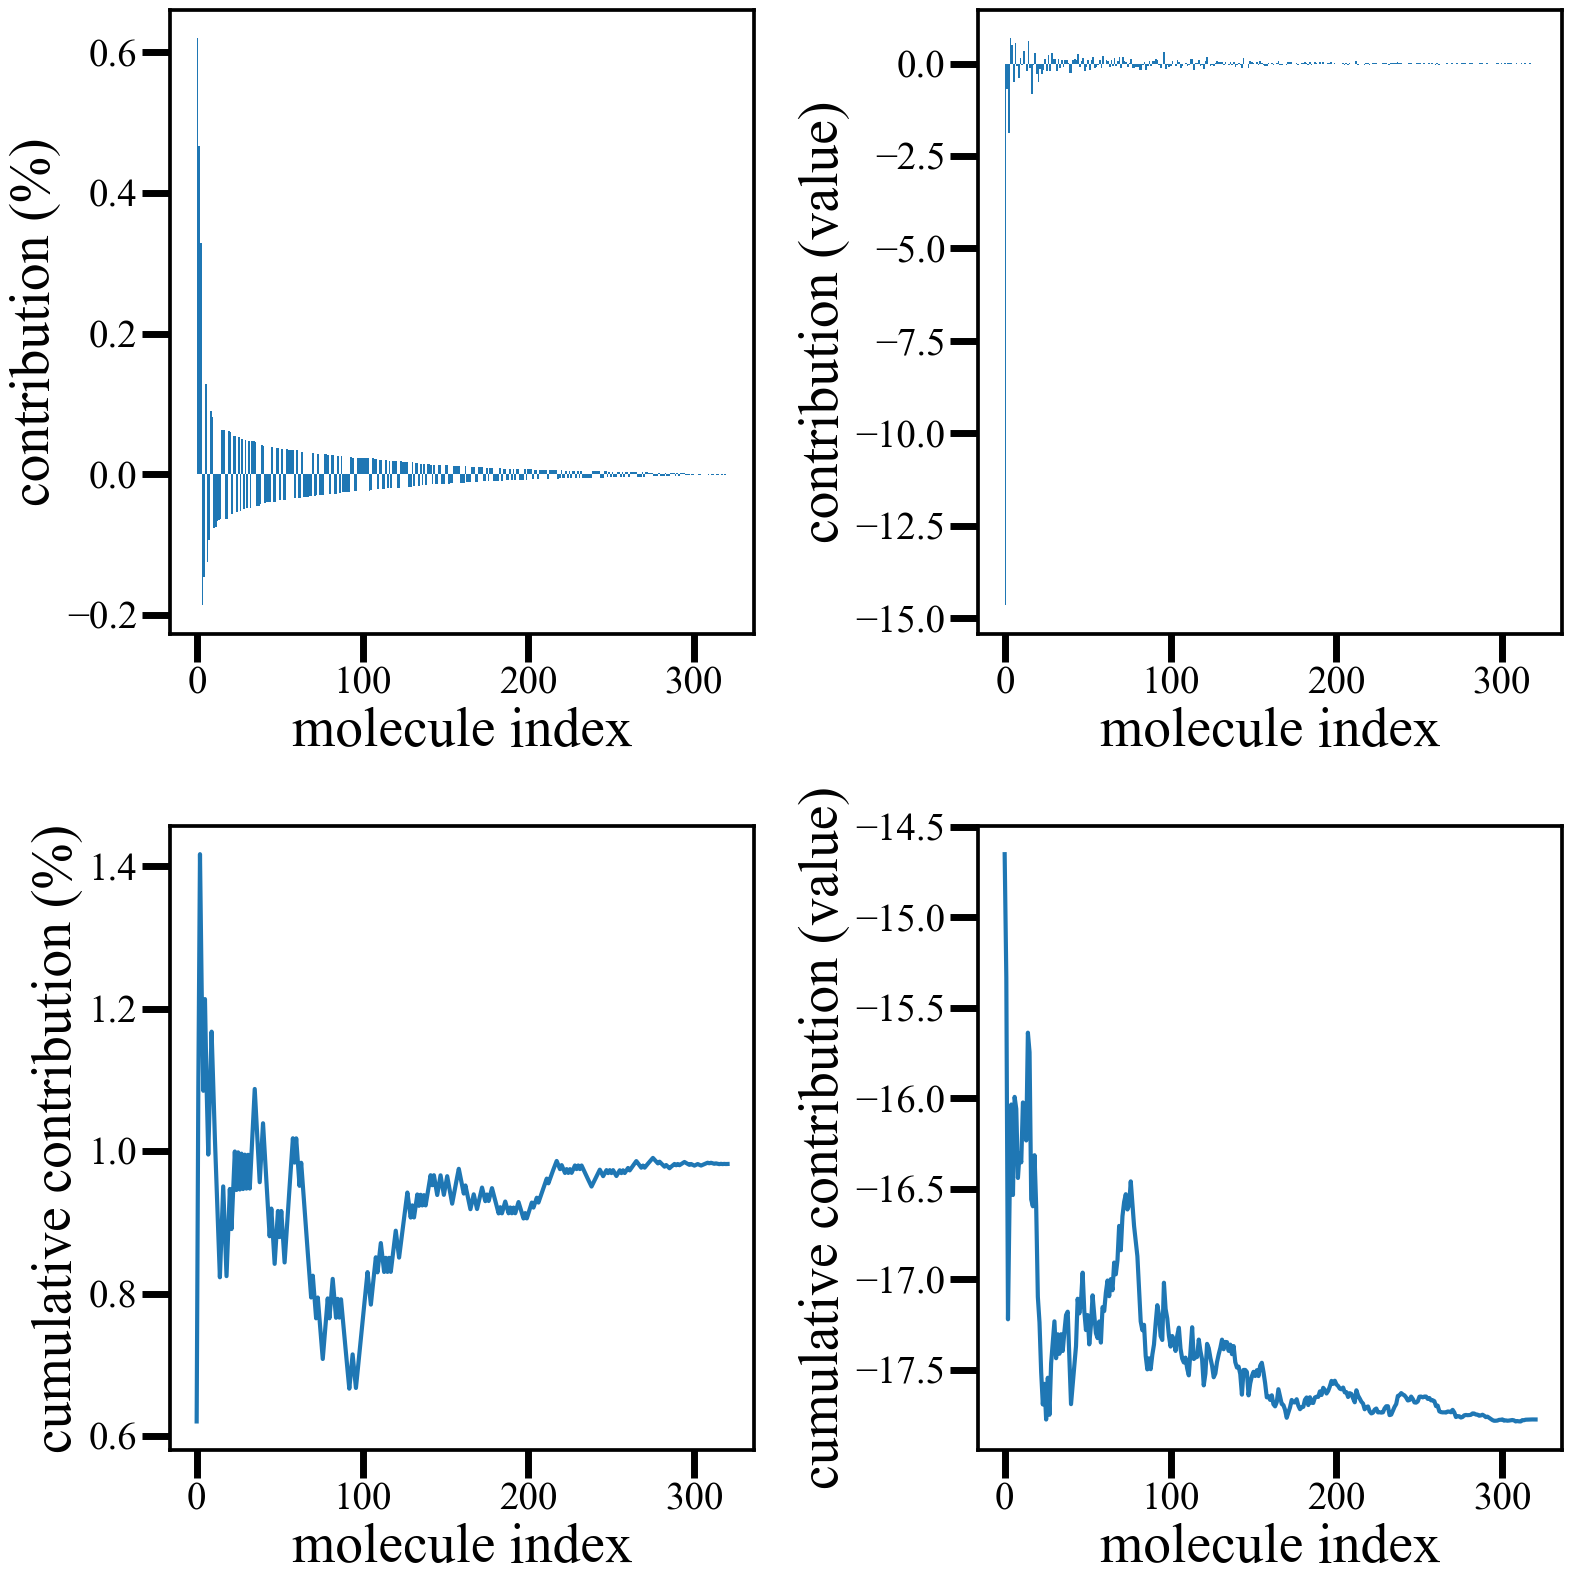

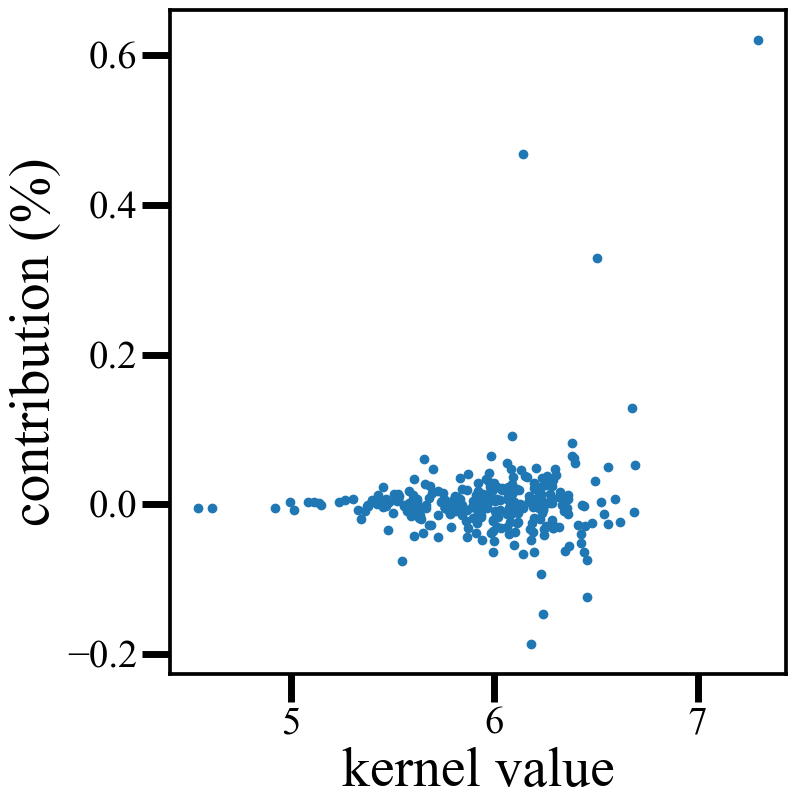

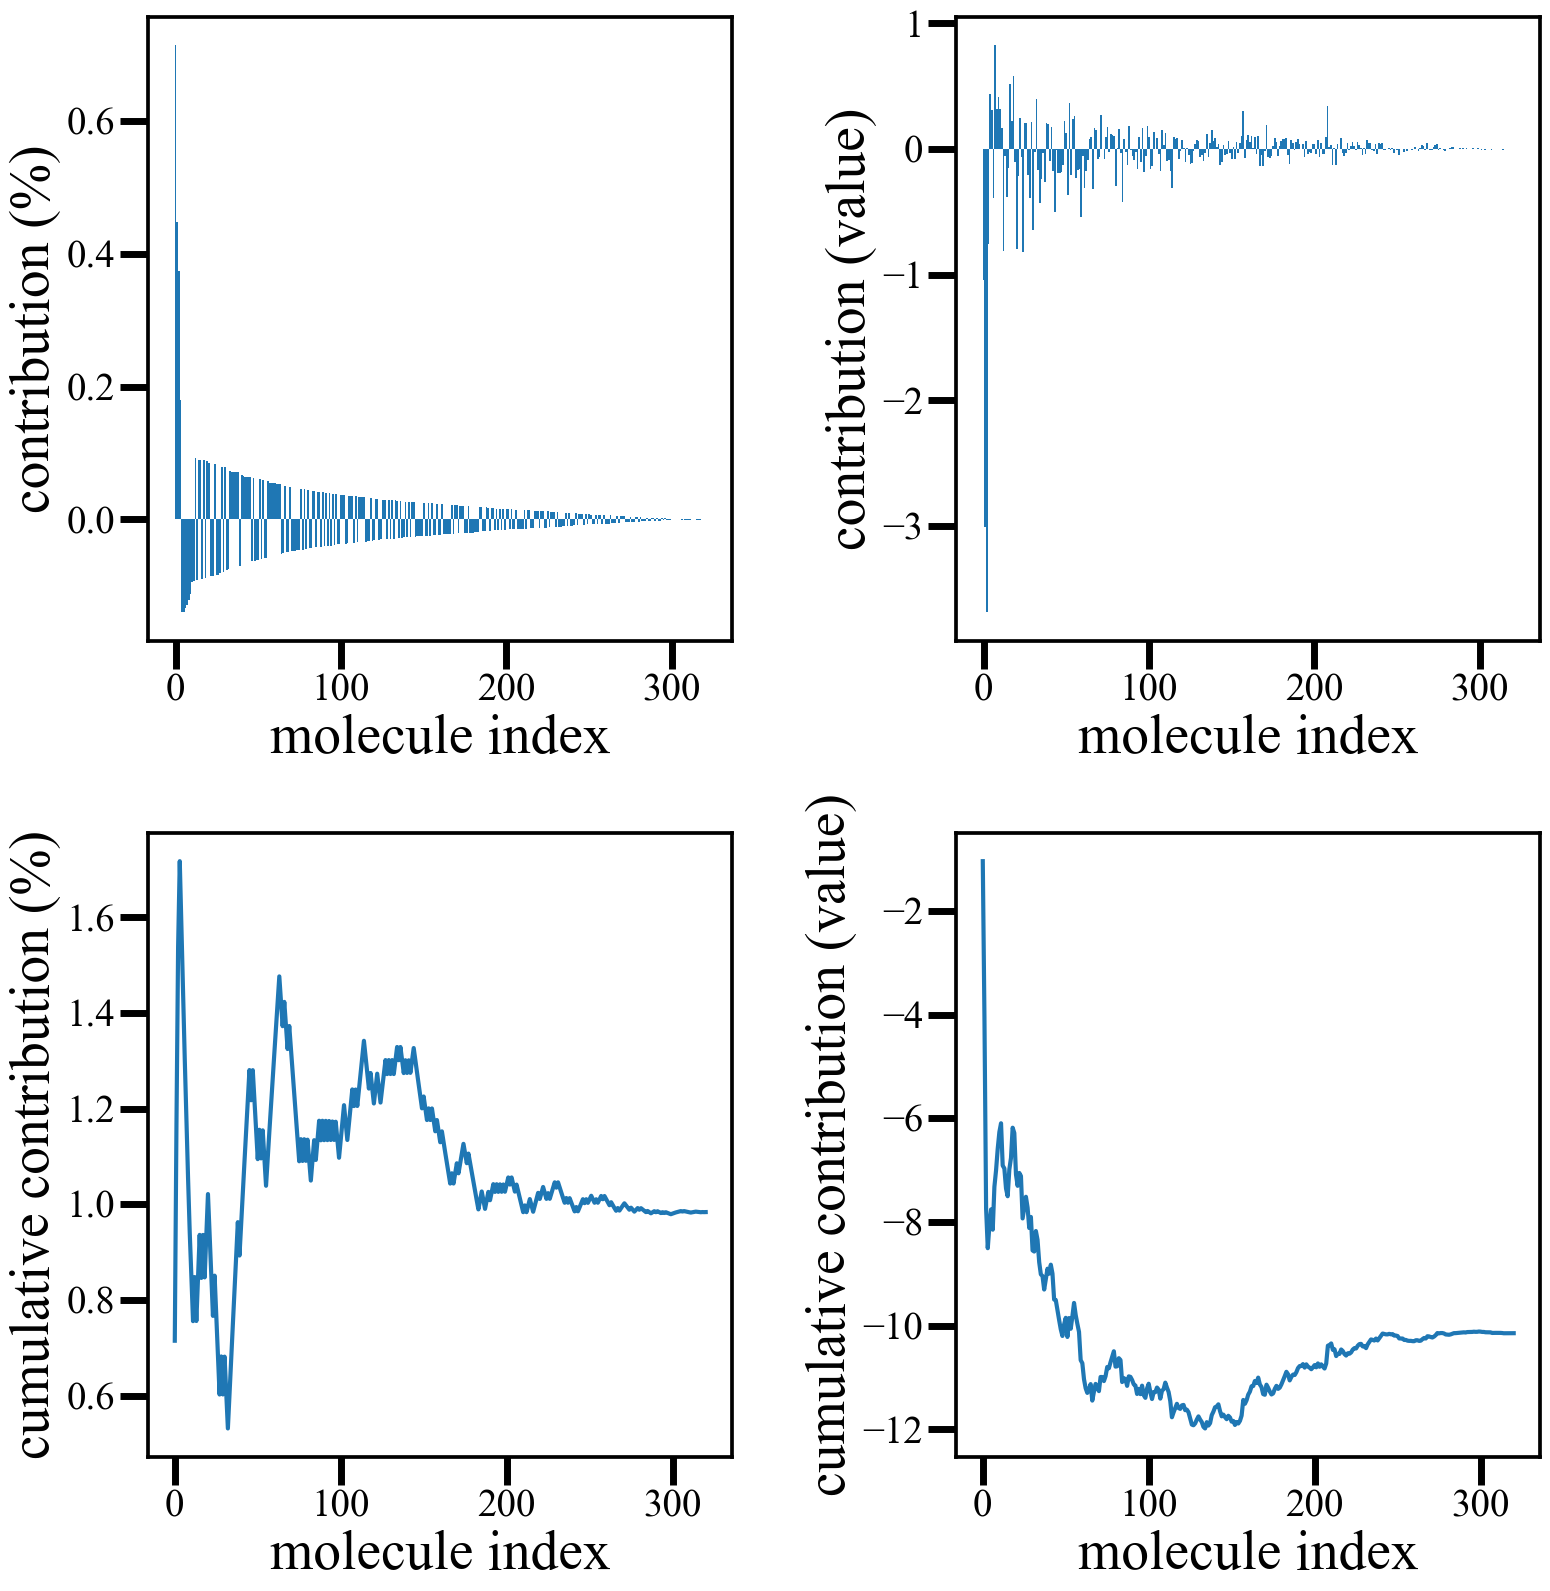

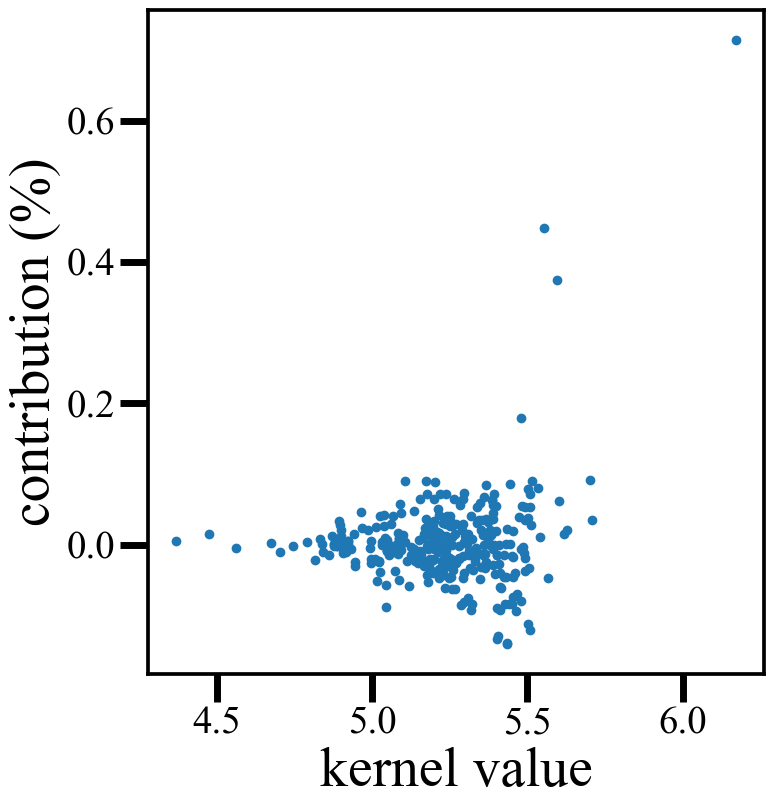

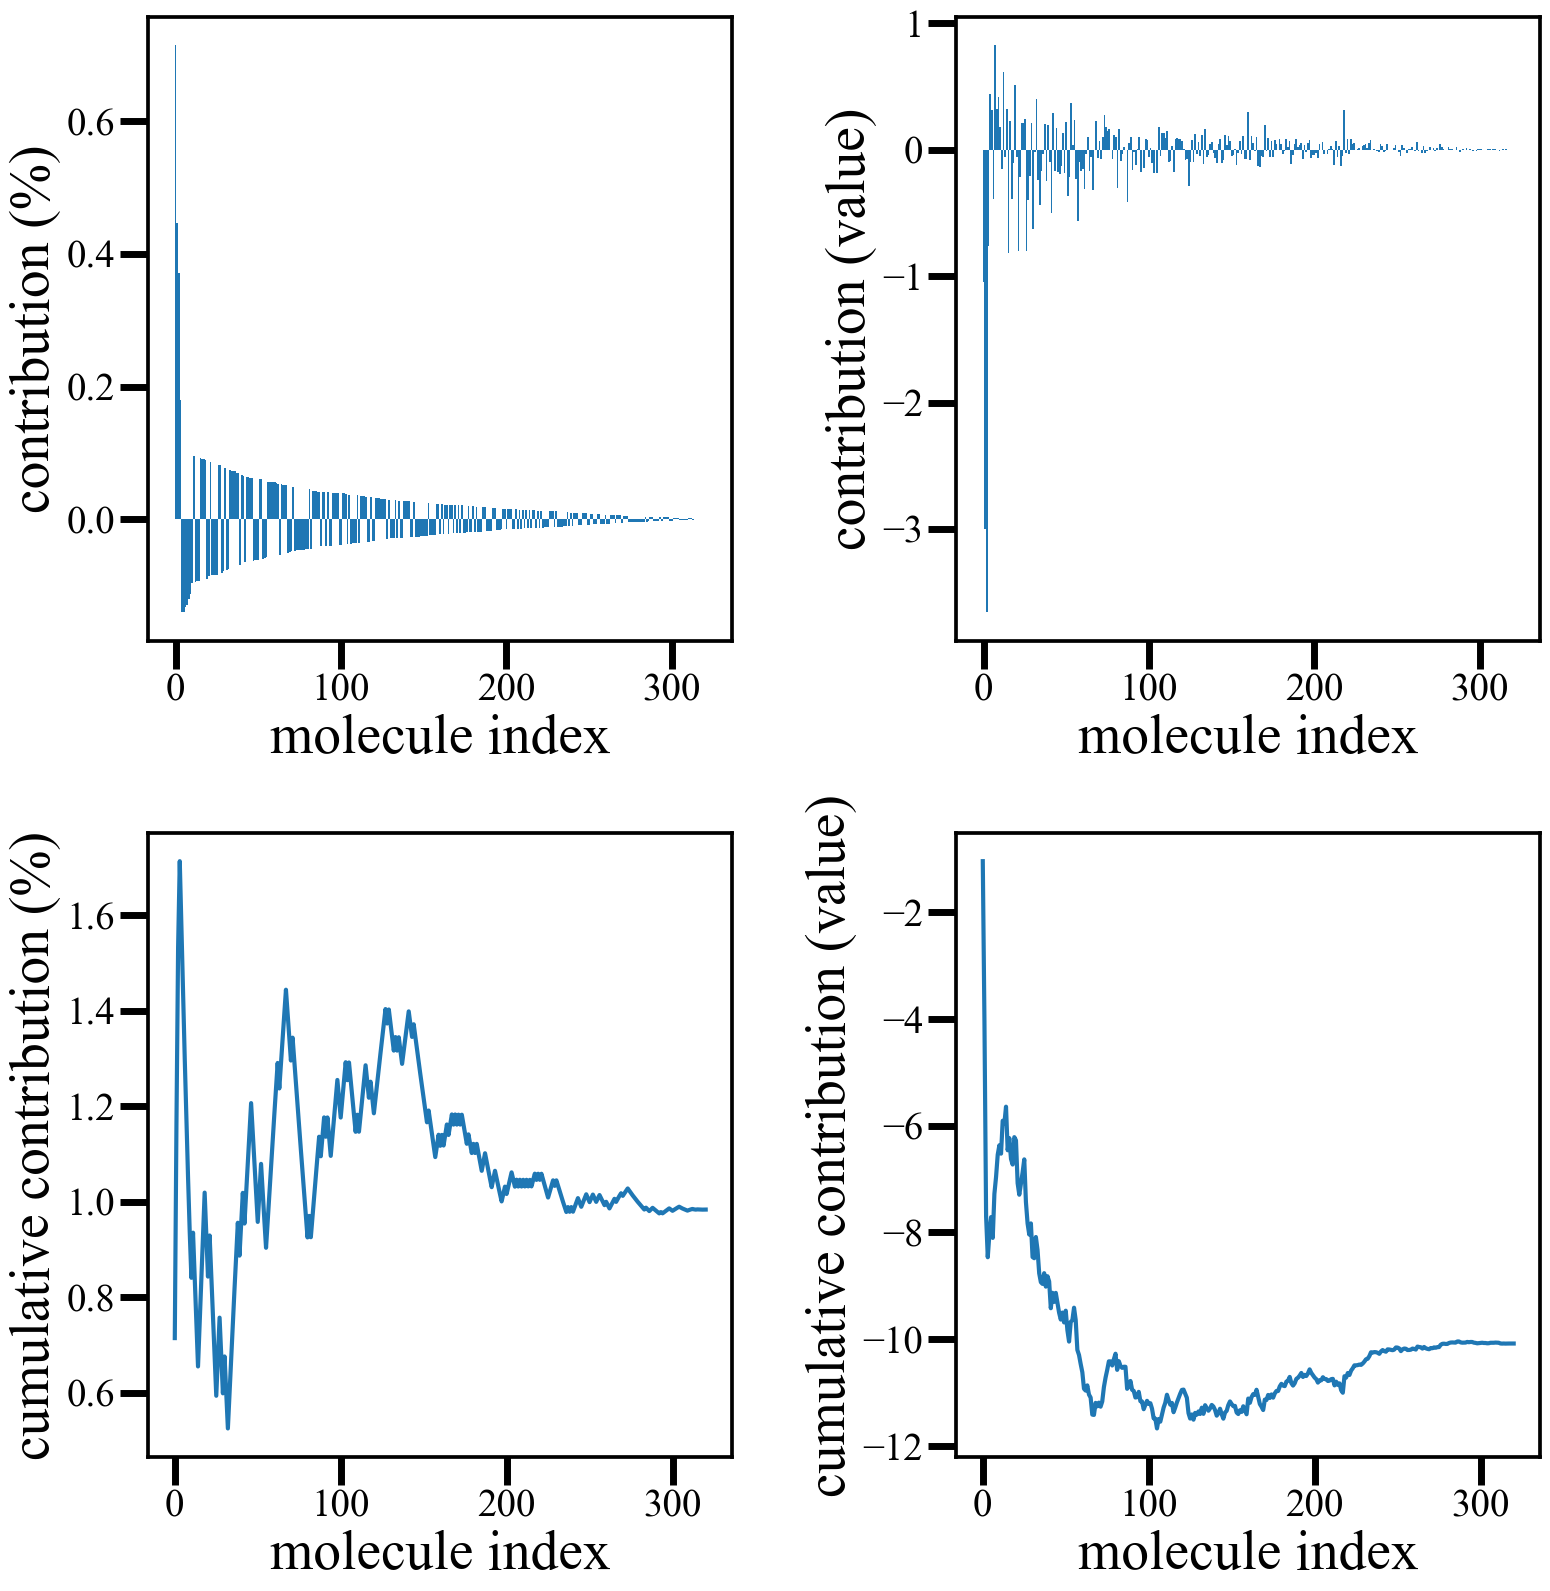

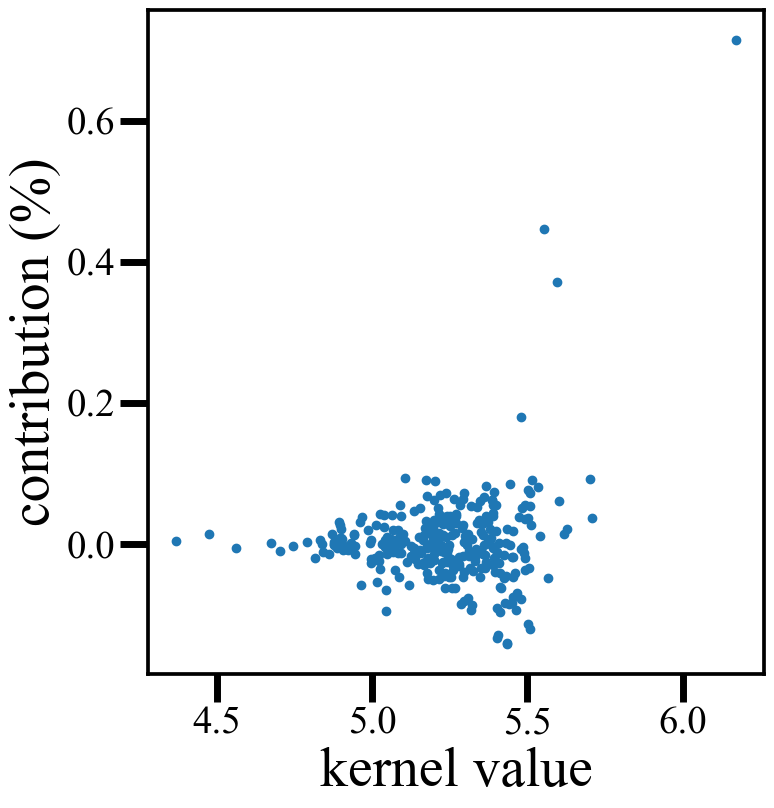

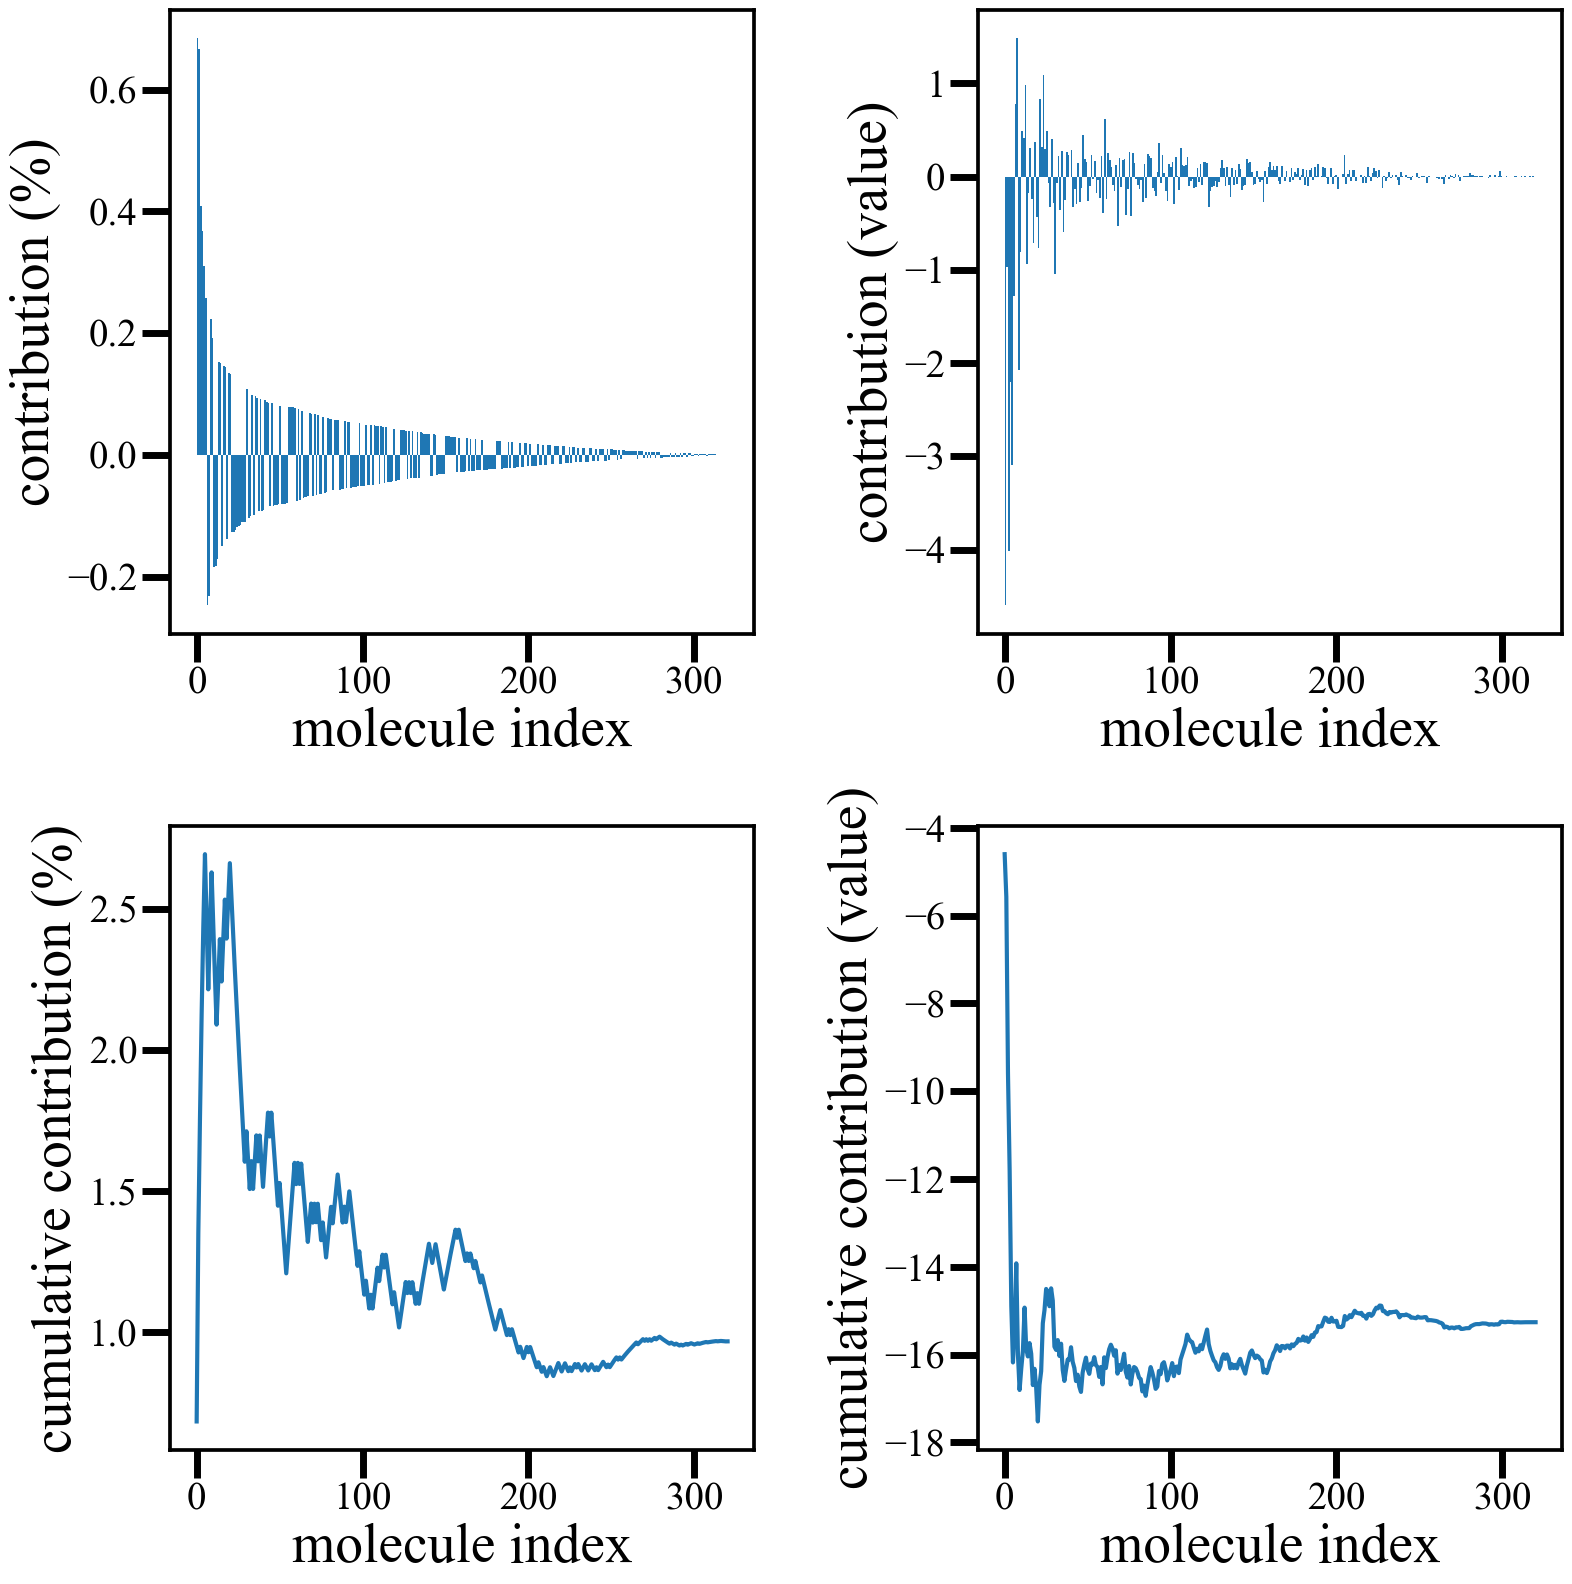

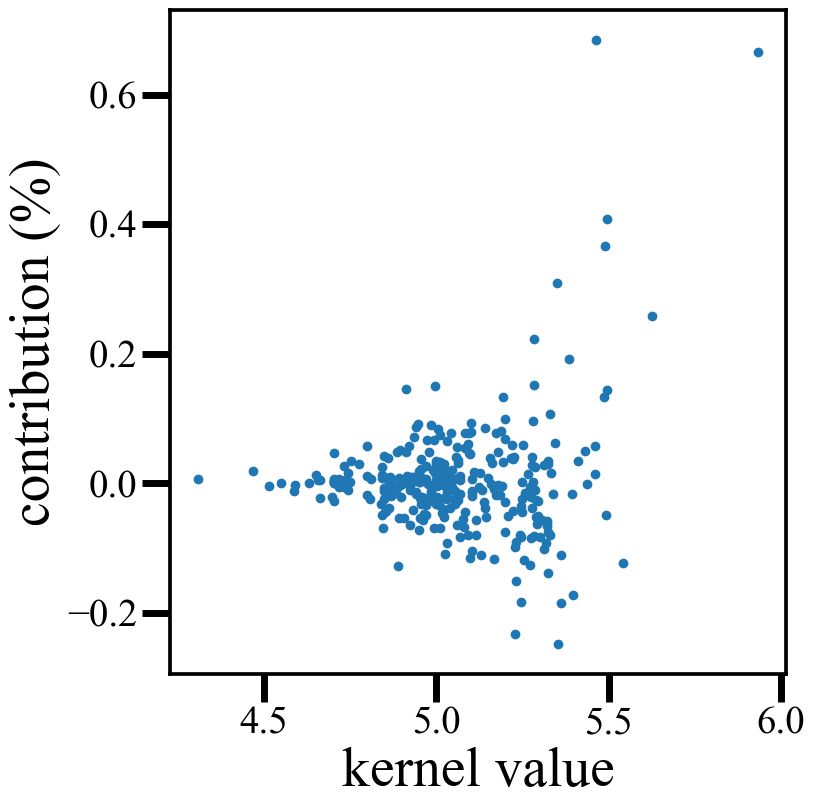

In [9]:
# graph kernel
df_mgk = []
for i, smiles_to_be_interpret in enumerate(smiles_list):
    mol_i = Chem.MolFromSmiles(smiles_to_be_interpret)
    y_pred, y_std, df_interpret= interpret_training_mols(
        smiles_to_be_interpret, 
        smiles_train, 
        targets_train, 
        alpha=alpha, 
        n_mol=n_mol, 
        output_order='sort_by_percentage_contribution', 
        mgk_hyperparameters_file='hyperopt-graph/hyperparameters_0.json',
        n_jobs=1, return_kernel=True)
    df_interpret = df_interpret[0]
    print(df_interpret)
    df_mgk.append(df_interpret)
    df_interpret['mol'] = df_interpret.smiles_train.apply(lambda x: Chem.MolFromSmiles(x))
    df_interpret['tag'] = df_interpret.apply(lambda x: r'%.2f X %.2f=%.2f' % (
        x.contribution_value / x.contribution_percentage, 
        x.contribution_percentage, 
        x.contribution_value), axis=1)
    img=Draw.MolsToGridImage(df_interpret.mol.tolist(),molsPerRow=4,
                             subImgSize=(200,200),
                             legends=df_interpret.tag.tolist(),
                             maxMols=12, useSVG=True)
    with open('mgk_top12_%d.svg' % i, "w") as f:
        f.write(img.data)
    
    fs = 8
    params = {'legend.fontsize': '%s' % (3.5 * fs),
              'figure.figsize': (fs * 2, fs * 2),  # 8*6
              'axes.labelsize': '%s' % (5 * fs),
              'axes.titlesize': '%s' % (5 * fs),
              'xtick.labelsize': '%s' % (3.5 * fs),
              'ytick.labelsize': '%s' % (3.5 * fs),
              'font.family': 'serif',
              'font.serif': 'Times New Roman',
              'axes.linewidth': fs / 3,
              }
    pylab.rcParams.update(params)
    fig = plt.figure()
    fig.tight_layout()

    dxs = [0.11, 0.14, 0.02]  # left to right
    dx = (1 - sum(dxs)) / (len(dxs) - 1)
    dys = [0.08, 0.12, 0.02]  # down to top
    dy = (1 - sum(dys)) / (len(dys) - 1)

    nx = 1
    ny = 2
    ax = fig.add_axes(
        [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
    ax.tick_params(width=5, length=20)
    ax.bar(df_interpret.index, df_interpret.contribution_percentage, width=1.0)
    ax.set_xlabel('molecule index')
    ax.set_ylabel('contribution (%)')


    nx = 2
    ny = 2
    ax = fig.add_axes(
        [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
    ax.tick_params(width=5, length=20)
    ax.bar(df_interpret.index, df_interpret.contribution_value, width=1.0)
    ax.set_xlabel('molecule index')
    ax.set_ylabel('contribution (value)')

    nx = 1
    ny = 1
    ax = fig.add_axes(
        [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
    ax.tick_params(width=5, length=20)
    accumulate_sum = np.cumsum(df_interpret.contribution_percentage)
    ax.plot(df_interpret.index, accumulate_sum, linewidth=3)
    ax.set_xlabel('molecule index')
    ax.set_ylabel('cumulative contribution (%)')

    nx = 2
    ny = 1
    ax = fig.add_axes(
        [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
    ax.tick_params(width=5, length=20)
    accumulate_sum = np.cumsum(df_interpret.contribution_value)
    ax.plot(df_interpret.index, accumulate_sum,  linewidth=3)
    ax.set_xlabel('molecule index')
    ax.set_ylabel('cumulative contribution (value)')
    
    plt.savefig('mgk_spectrum_%d.png' % i)
    
    params = {'legend.fontsize': '%s' % (3.5 * fs),
          'figure.figsize': (fs, fs),  # 8*6
          'axes.labelsize': '%s' % (5 * fs),
          'axes.titlesize': '%s' % (5 * fs),
          'xtick.labelsize': '%s' % (3.5 * fs),
          'ytick.labelsize': '%s' % (3.5 * fs),
          'font.family': 'serif',
          'font.serif': 'Times New Roman',
          'axes.linewidth': fs / 3,
          }
    pylab.rcParams.update(params)
    fig = plt.figure()
    fig.tight_layout()

    dxs = [0.21, 0.02]  # left to right
    dx = (1 - sum(dxs)) / (len(dxs) - 1)
    dys = [0.15, 0.02]  # down to top
    dy = (1 - sum(dys)) / (len(dys) - 1)
    nx = 1
    ny = 1
    ax = fig.add_axes(
        [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
    ax.tick_params(width=5, length=20)       
    ax.scatter(df_interpret['kernel'], df_interpret['contribution_percentage'])                                    
    ax.set_xlabel('kernel value')
    ax.set_ylabel('contribution (%)')
    
    plt.savefig('mgk_contribution_vs_kernel_%d.png' % i)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    0.7s finished
/home/xiangyan/workspace/apps/miniconda3/envs/graph-attribution/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 12. Change the maxMols value to display more.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    0.5s finished
/home/xiangyan/workspace/apps/miniconda3/envs/graph-attribution/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: User

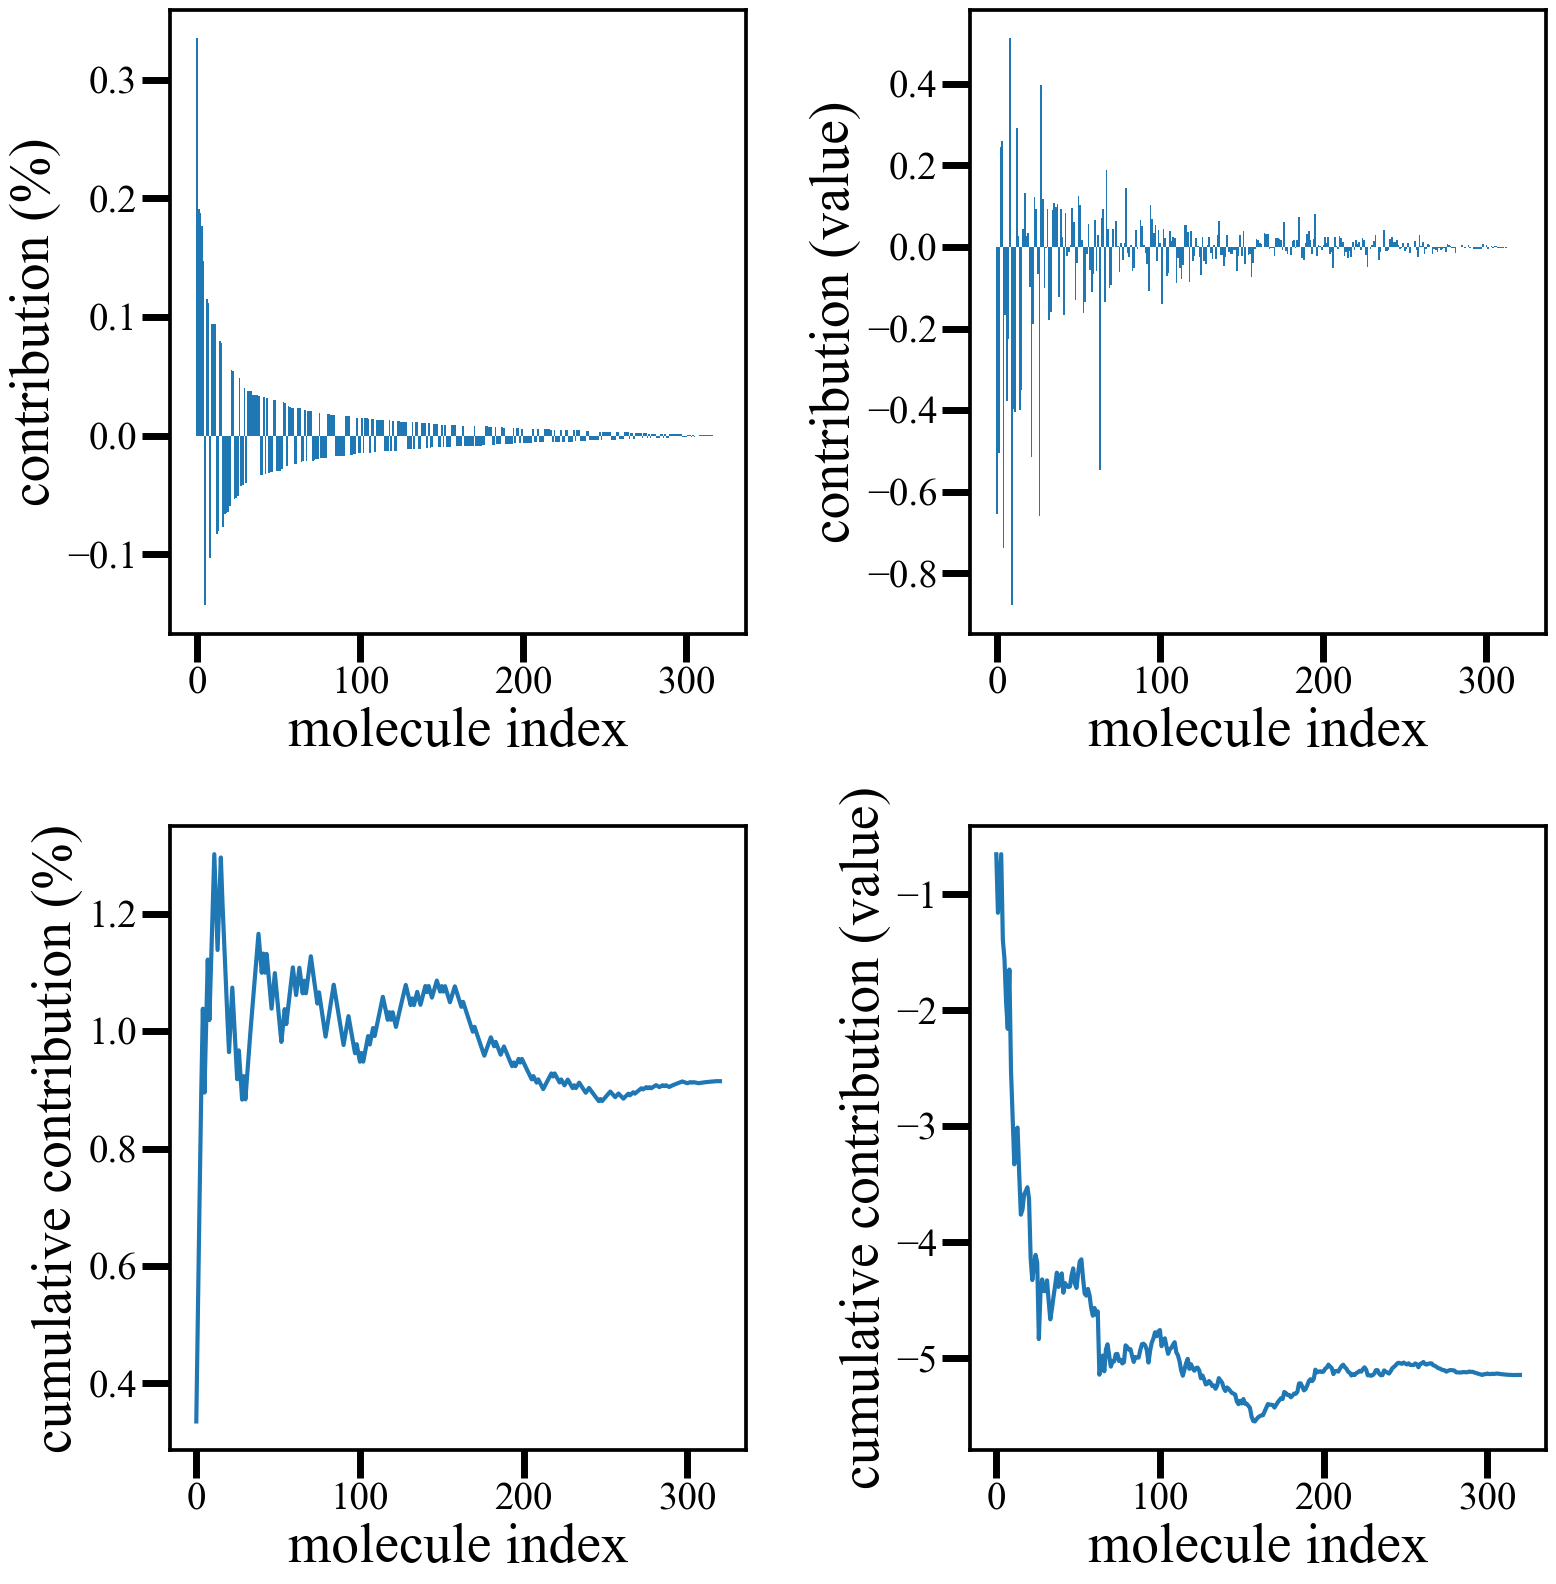

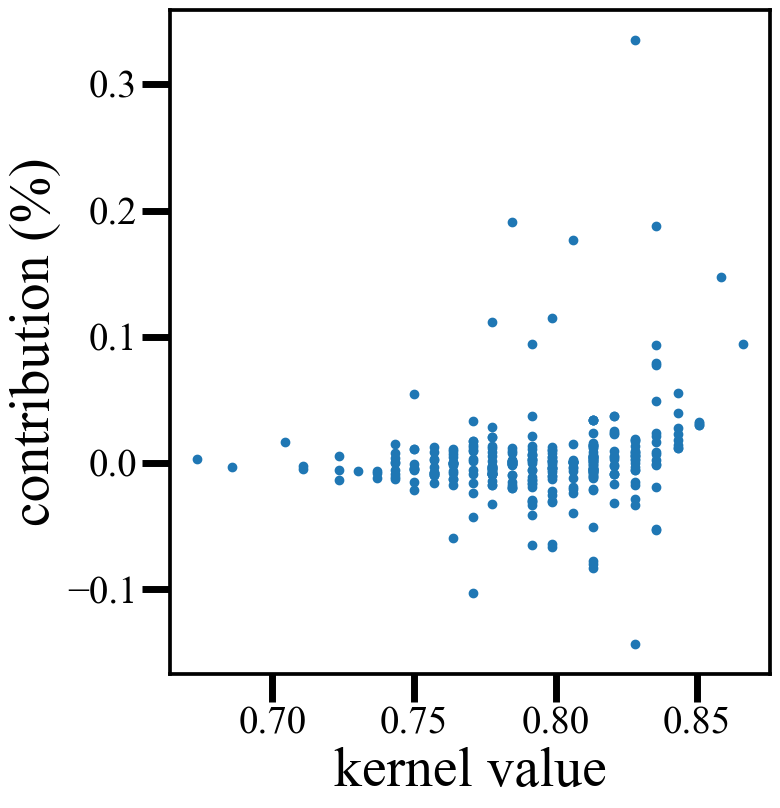

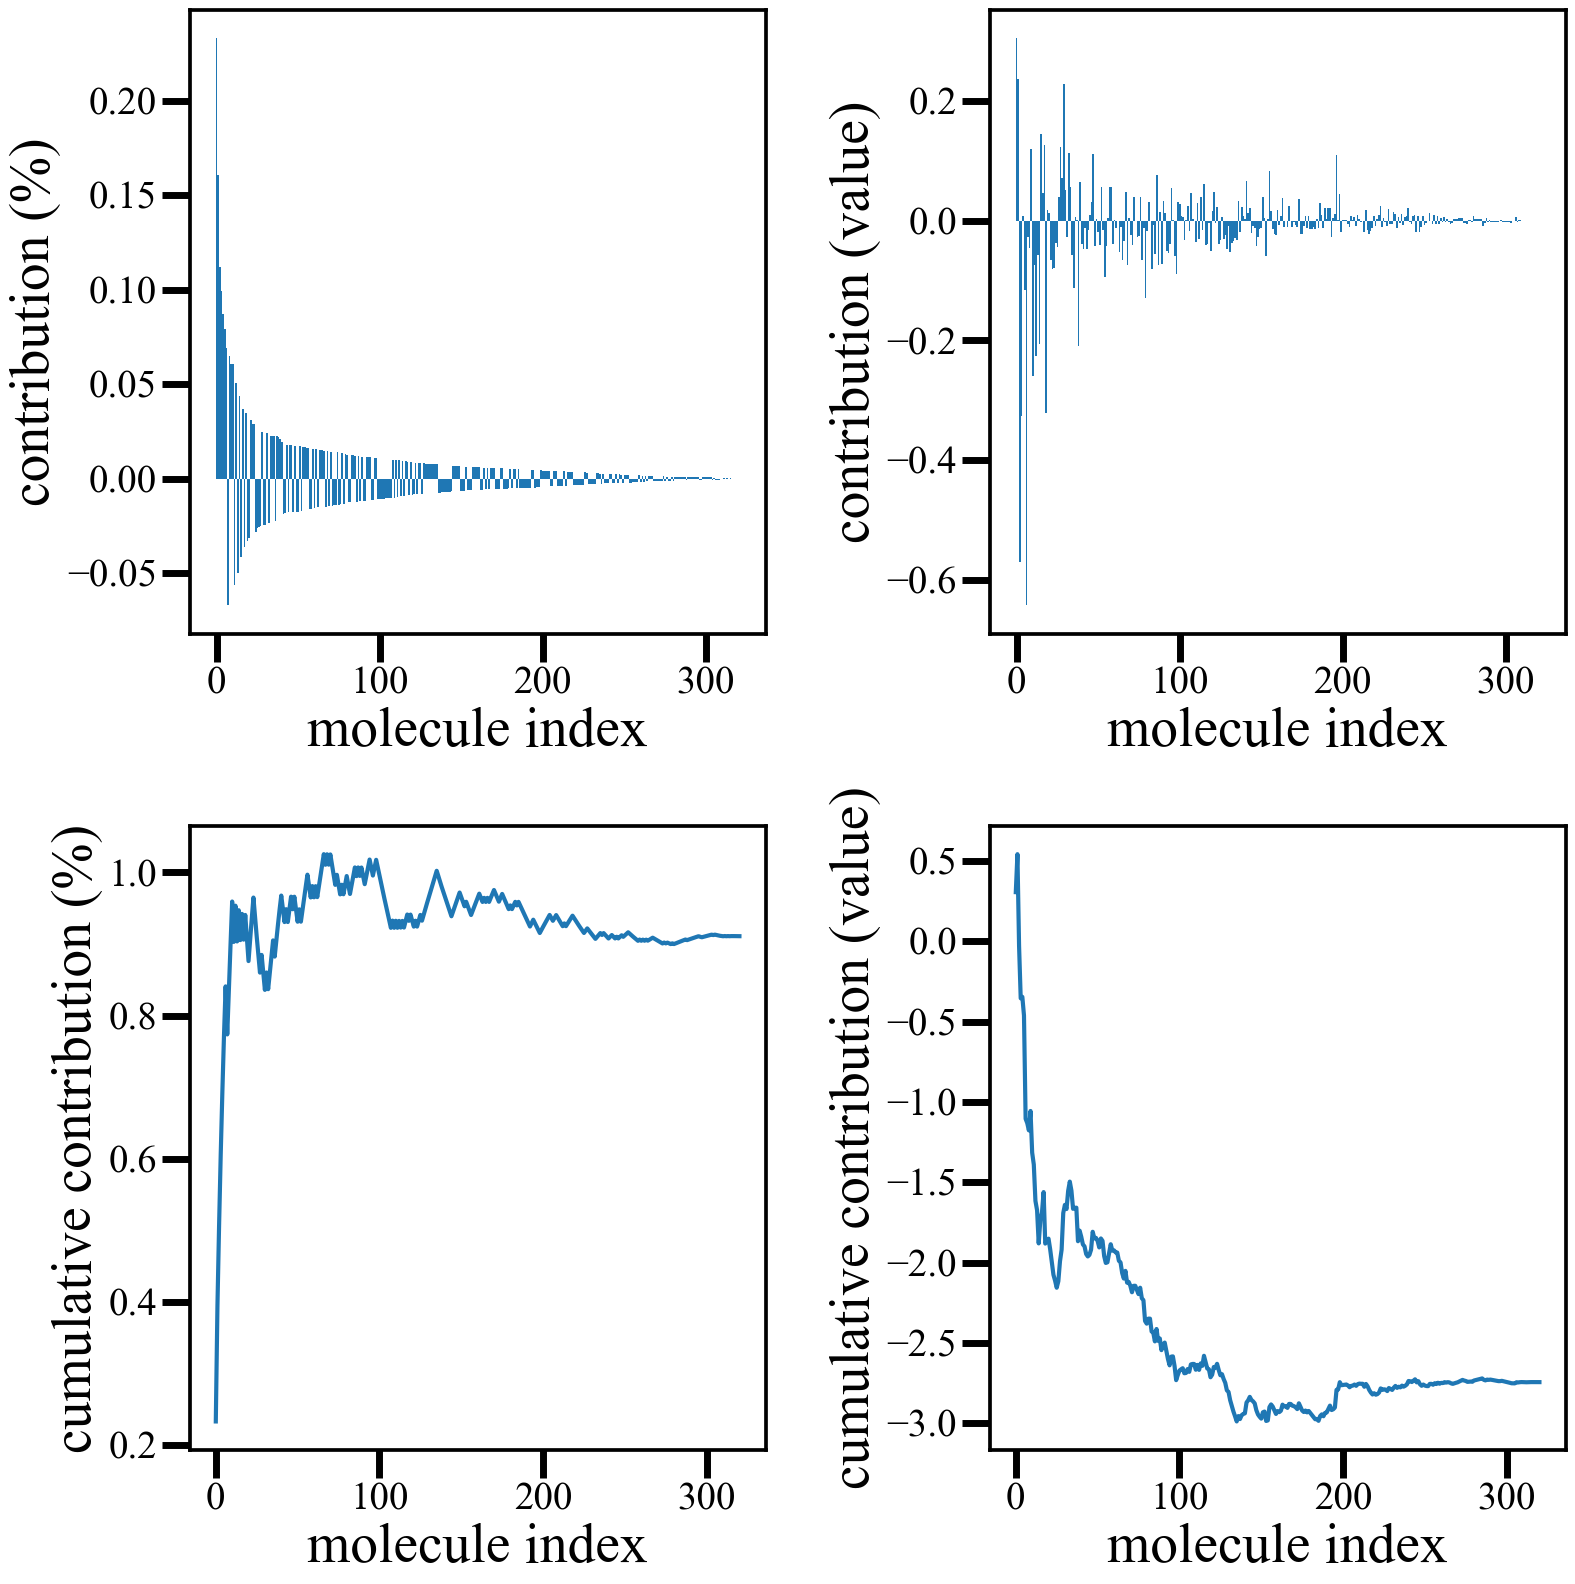

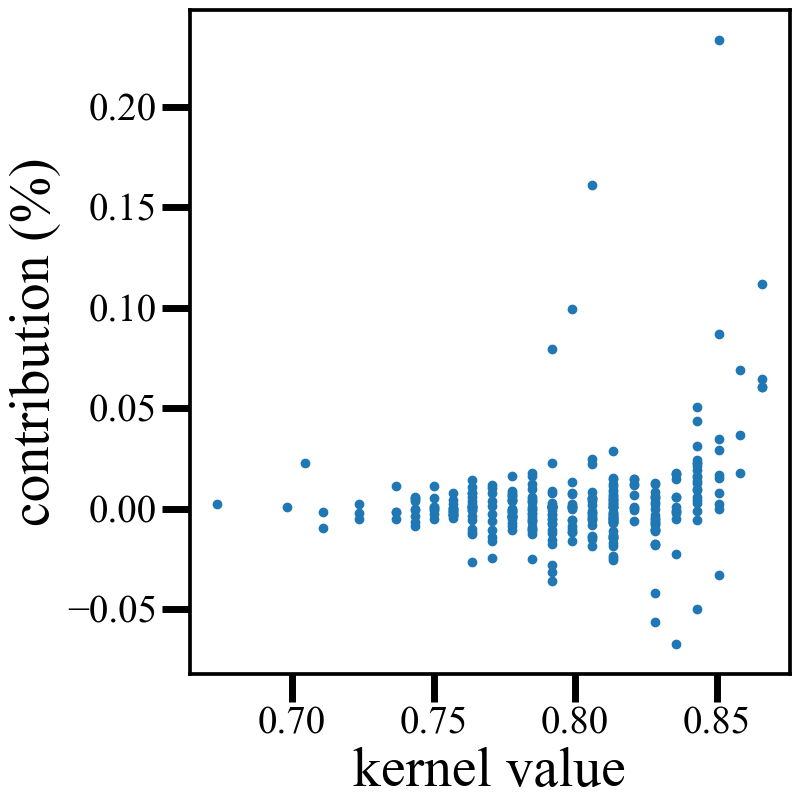

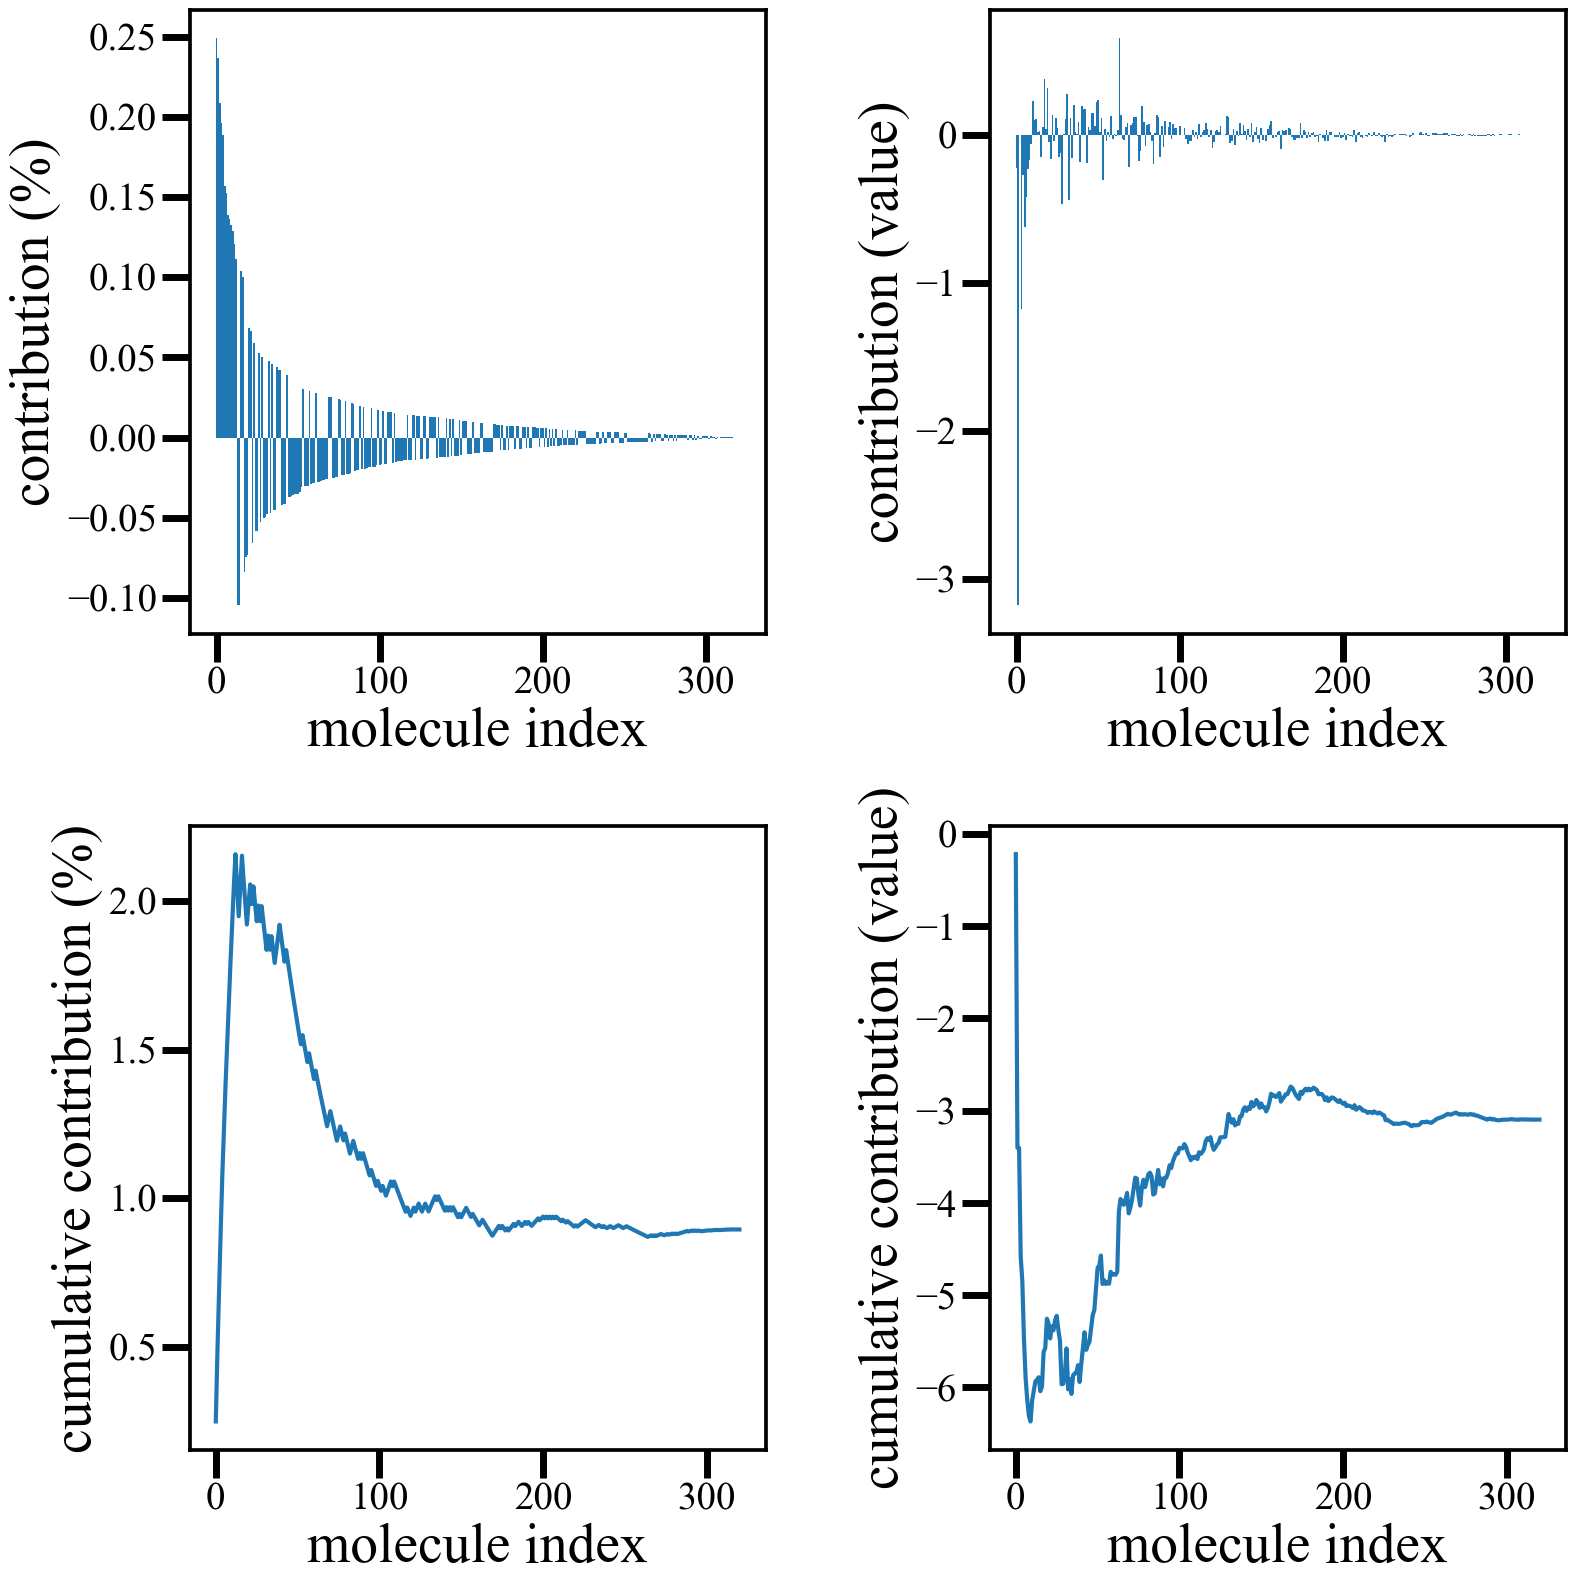

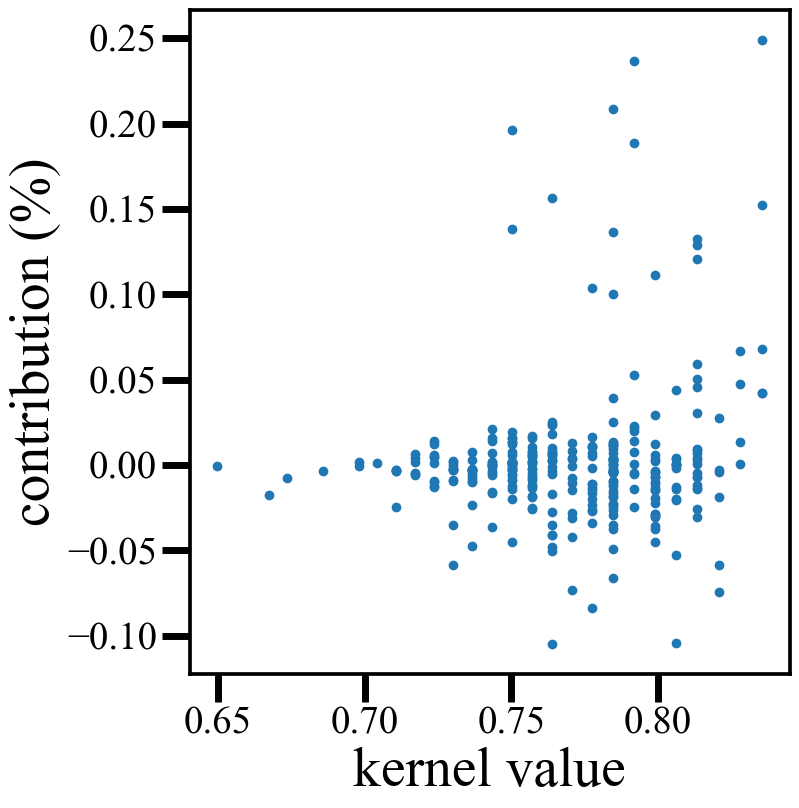

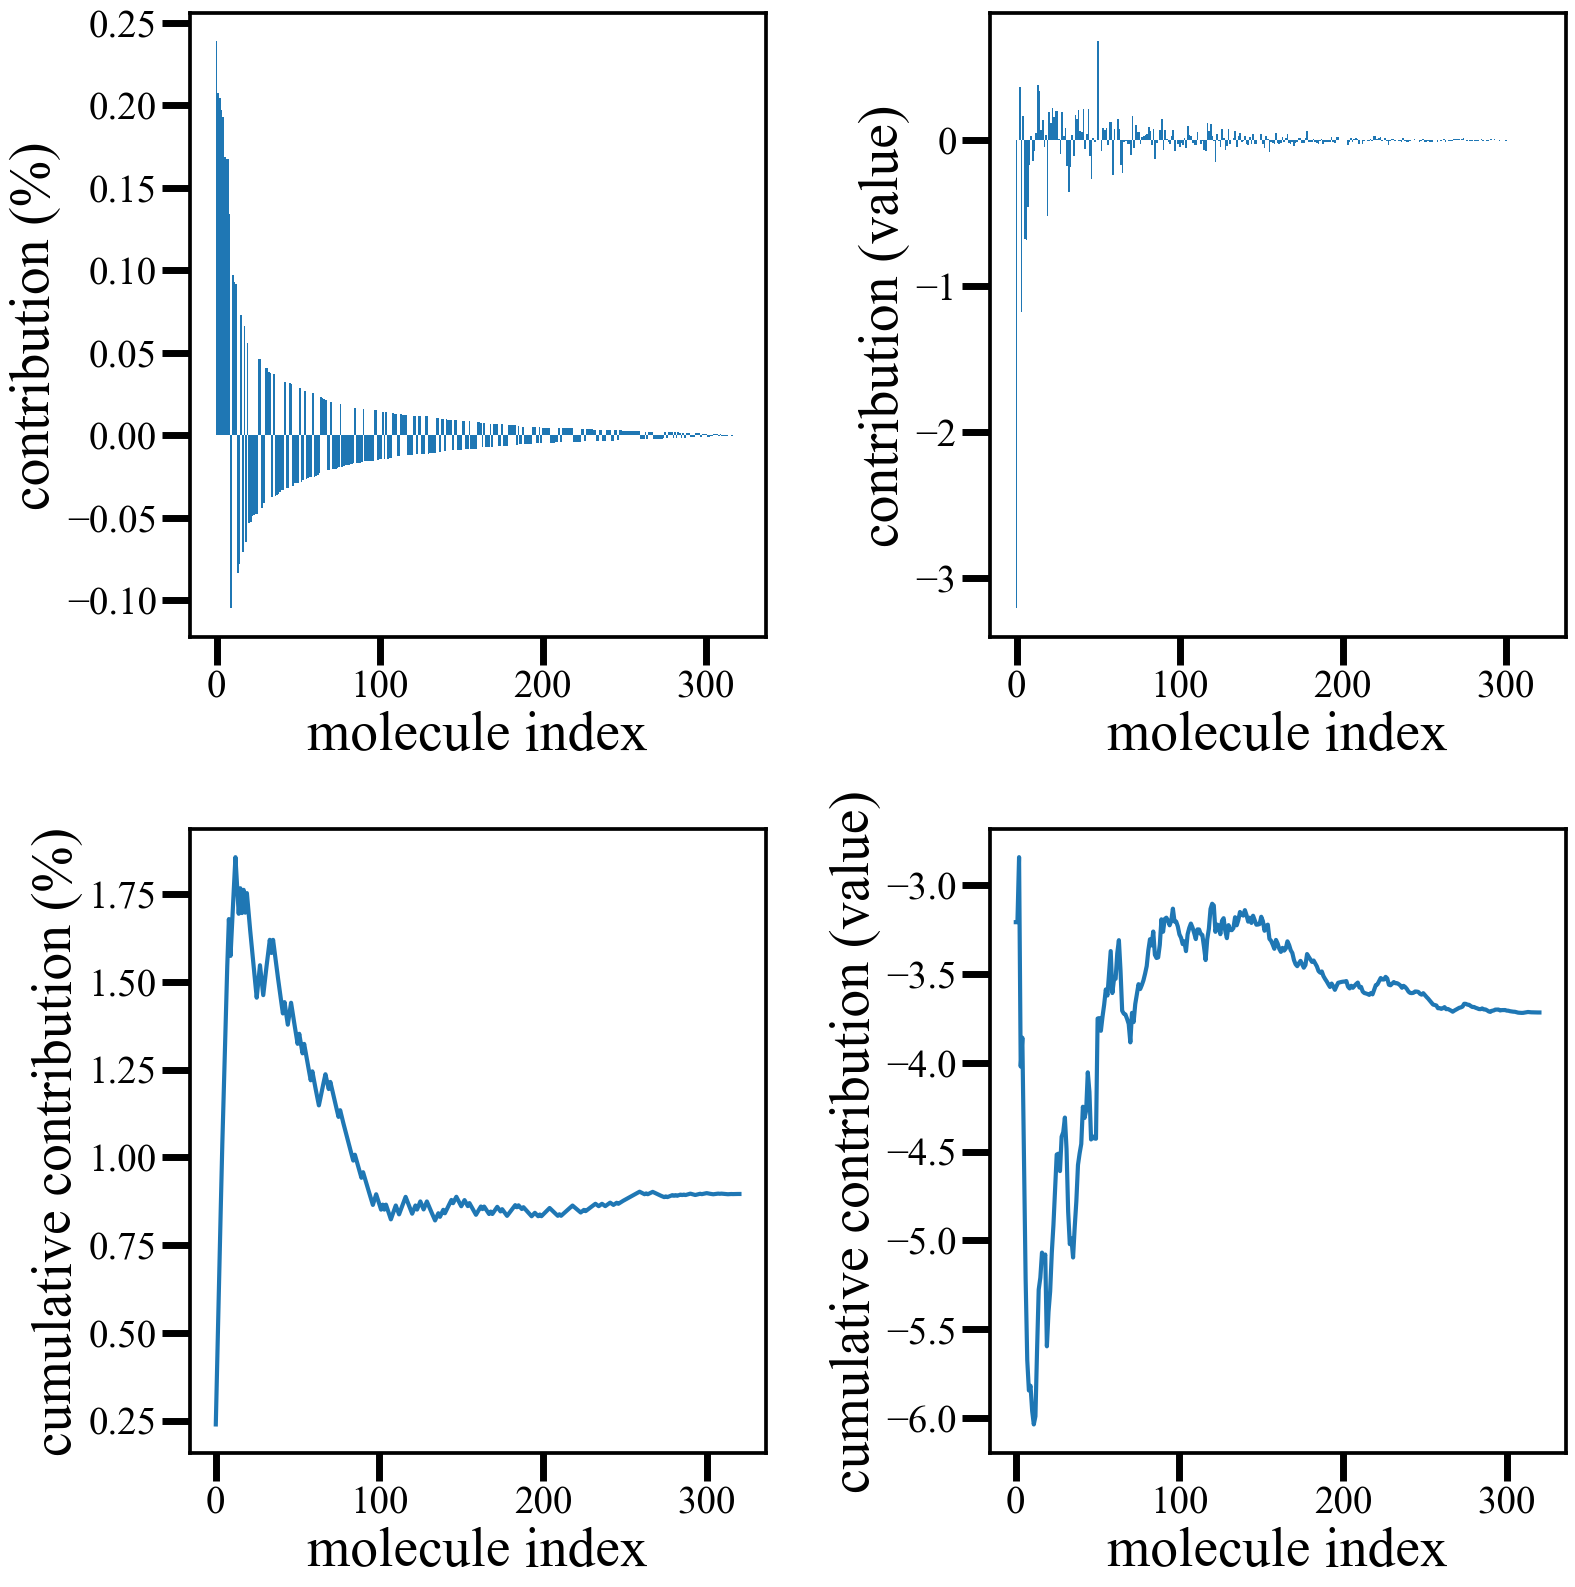

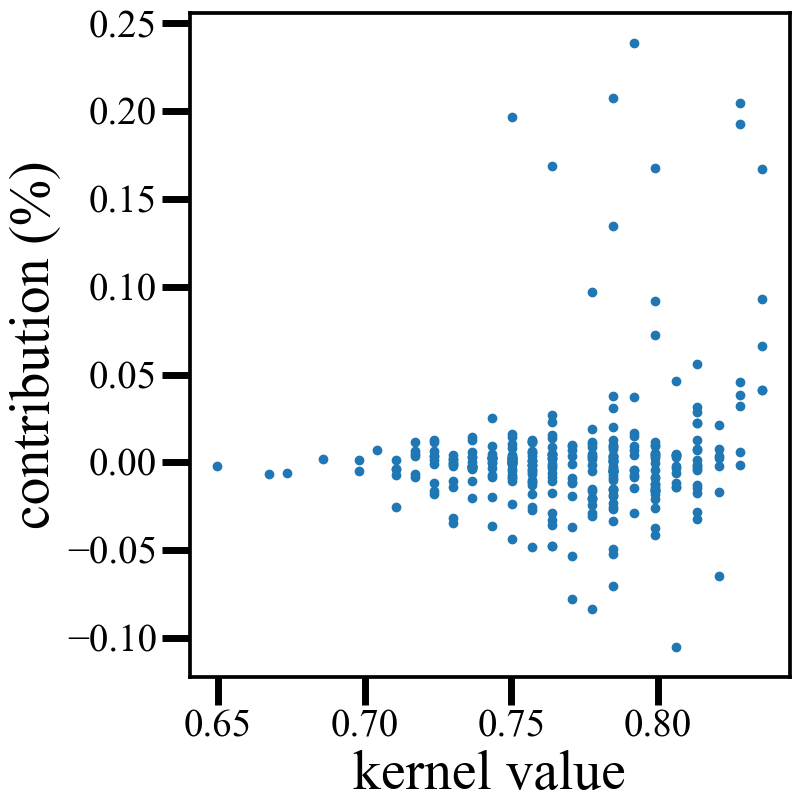

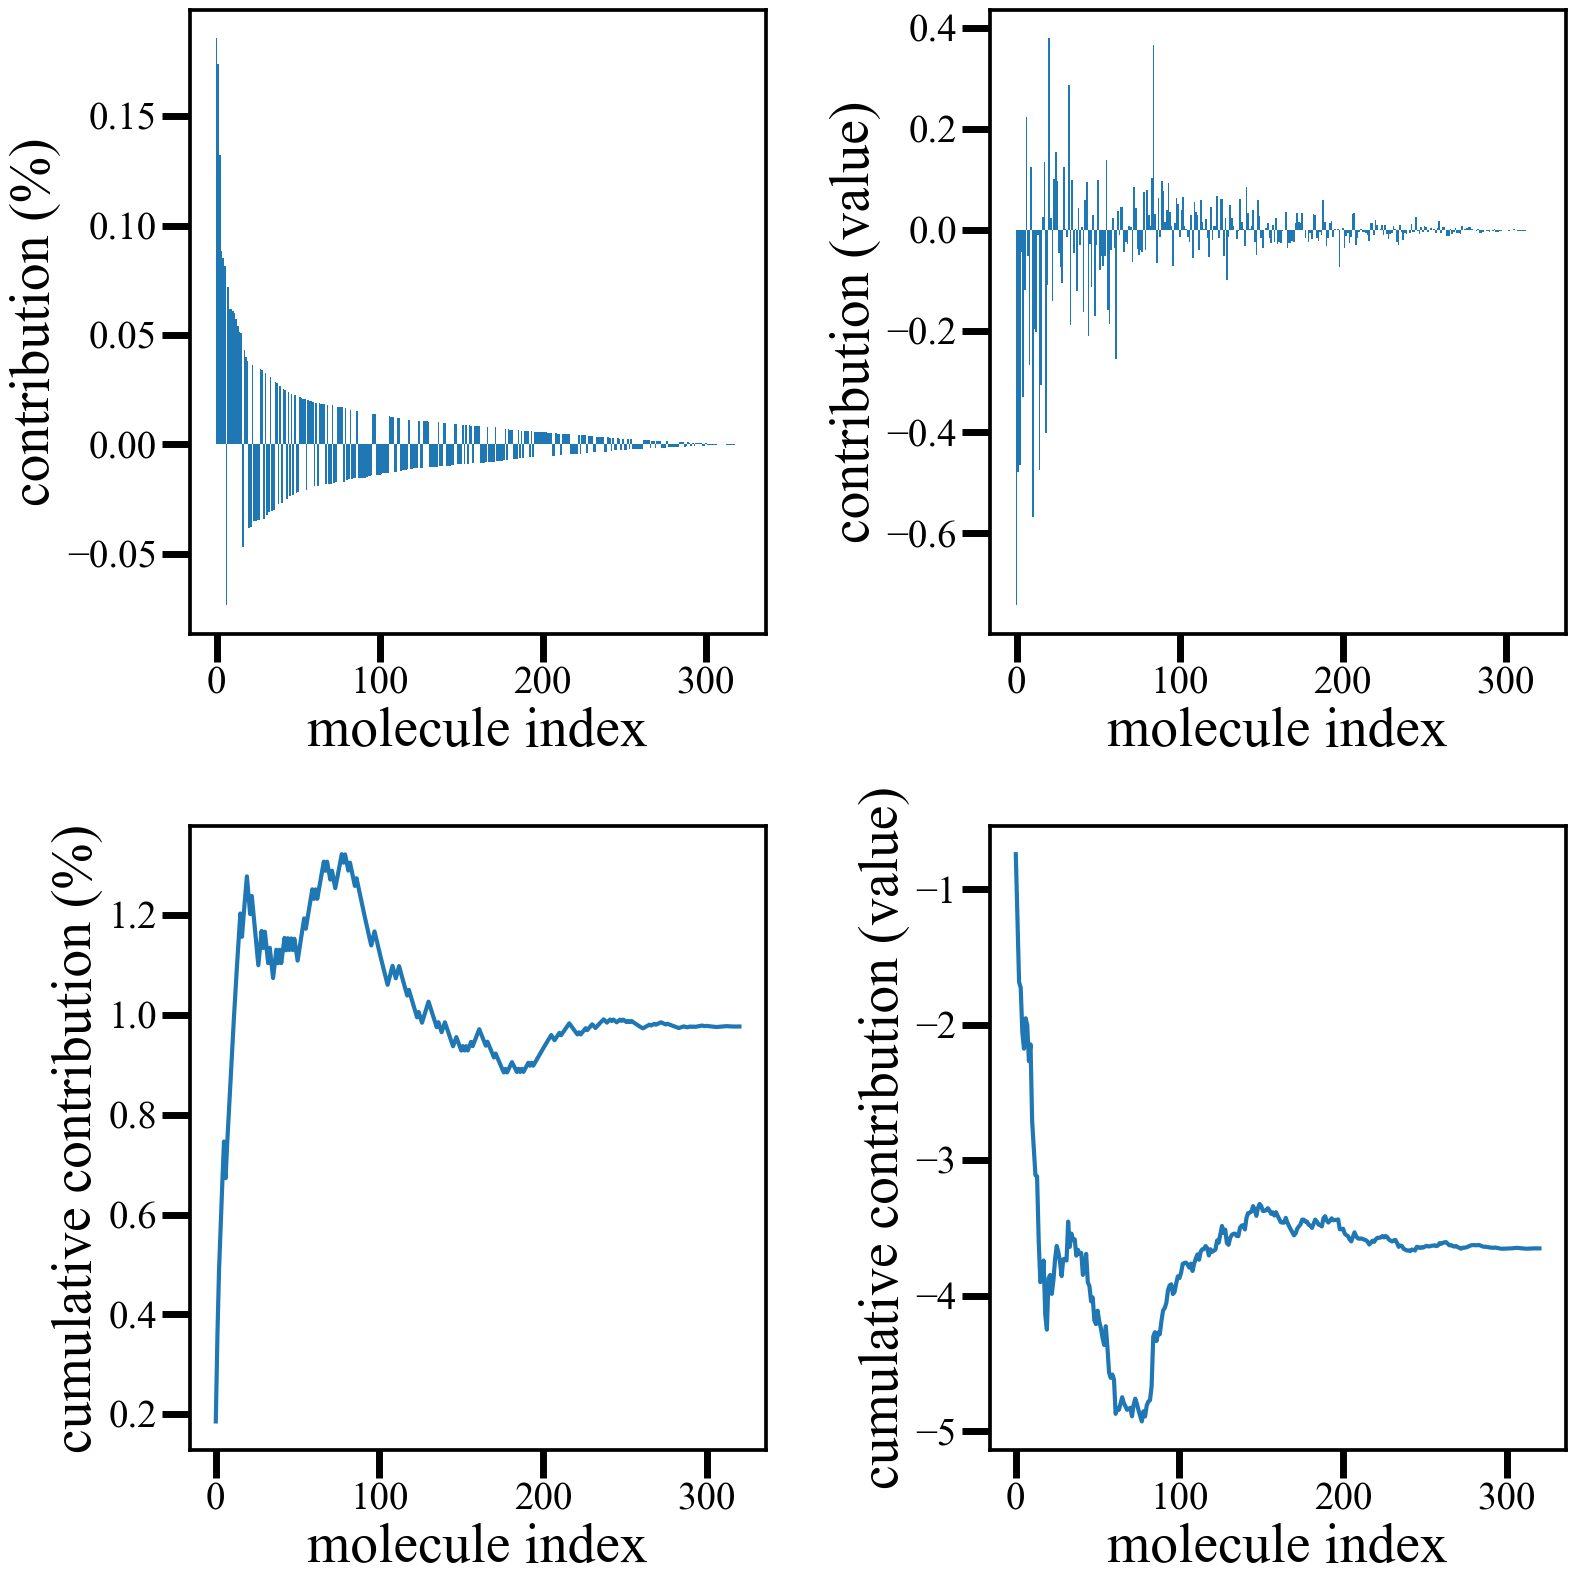

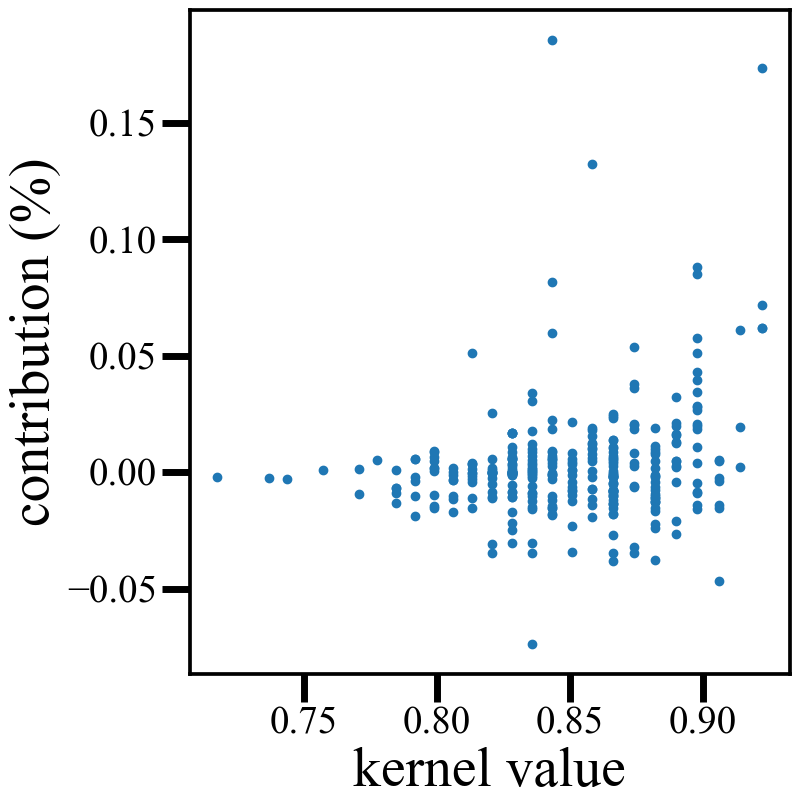

In [10]:
# GPR-RBF-Morgan 
df_morgan = []
for i, smiles_to_be_interpret in enumerate(smiles_list):
    mol_i = Chem.MolFromSmiles(smiles_to_be_interpret)
    y_pred, y_std, df_interpret= interpret_training_mols(
        smiles_to_be_interpret, 
        smiles_train, 
        targets_train, 
        alpha=alpha, 
        n_mol=n_mol, 
        output_order='sort_by_percentage_contribution', 
        mgk_hyperparameters_file=None,
        features_hyperparameters_file='hyperopt-morgan/features_hyperparameters.json',
        features_generator = ['morgan'],
        n_jobs=1, return_kernel=True)
    df_interpret = df_interpret[0]
    df_morgan.append(df_interpret)
    df_interpret['mol'] = df_interpret.smiles_train.apply(lambda x: Chem.MolFromSmiles(x))
    df_interpret['tag'] = df_interpret.apply(lambda x: r'%.2f X %.2f=%.2f' % (
        x.contribution_value / x.contribution_percentage, 
        x.contribution_percentage, 
        x.contribution_value), axis=1)
    img=Draw.MolsToGridImage(df_interpret.mol.tolist(),molsPerRow=4,
                             subImgSize=(200,200),
                             legends=df_interpret.tag.tolist(),
                             maxMols=12, useSVG=True)
    with open('morgan_top12_%d.svg' % i, "w") as f:
        f.write(img.data)
    
    fs = 8
    params = {'legend.fontsize': '%s' % (3.5 * fs),
              'figure.figsize': (fs * 2, fs * 2),  # 8*6
              'axes.labelsize': '%s' % (5 * fs),
              'axes.titlesize': '%s' % (5 * fs),
              'xtick.labelsize': '%s' % (3.5 * fs),
              'ytick.labelsize': '%s' % (3.5 * fs),
              'font.family': 'serif',
              'font.serif': 'Times New Roman',
              'axes.linewidth': fs / 3,
              }
    pylab.rcParams.update(params)
    fig = plt.figure()
    fig.tight_layout()

    dxs = [0.12, 0.14, 0.02]  # left to right
    dx = (1 - sum(dxs)) / (len(dxs) - 1)
    dys = [0.08, 0.12, 0.02]  # down to top
    dy = (1 - sum(dys)) / (len(dys) - 1)

    nx = 1
    ny = 2
    ax = fig.add_axes(
        [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
    ax.tick_params(width=5, length=20)
    ax.bar(df_interpret.index, df_interpret.contribution_percentage, width=1.0)
    ax.set_xlabel('molecule index')
    ax.set_ylabel('contribution (%)')


    nx = 2
    ny = 2
    ax = fig.add_axes(
        [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
    ax.tick_params(width=5, length=20)
    ax.bar(df_interpret.index, df_interpret.contribution_value, width=1.0)
    ax.set_xlabel('molecule index')
    ax.set_ylabel('contribution (value)')

    nx = 1
    ny = 1
    ax = fig.add_axes(
        [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
    ax.tick_params(width=5, length=20)
    accumulate_sum = np.cumsum(df_interpret.contribution_percentage)
    ax.plot(df_interpret.index, accumulate_sum, linewidth=3)
    ax.set_xlabel('molecule index')
    ax.set_ylabel('cumulative contribution (%)')

    nx = 2
    ny = 1
    ax = fig.add_axes(
        [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
    ax.tick_params(width=5, length=20)
    accumulate_sum = np.cumsum(df_interpret.contribution_value)
    ax.plot(df_interpret.index, accumulate_sum,  linewidth=3)
    ax.set_xlabel('molecule index')
    ax.set_ylabel('cumulative contribution (value)')
    
    plt.savefig('morgan_spectrum_%d.png' % i)
    
    params = {'legend.fontsize': '%s' % (3.5 * fs),
          'figure.figsize': (fs, fs),  # 8*6
          'axes.labelsize': '%s' % (5 * fs),
          'axes.titlesize': '%s' % (5 * fs),
          'xtick.labelsize': '%s' % (3.5 * fs),
          'ytick.labelsize': '%s' % (3.5 * fs),
          'font.family': 'serif',
          'font.serif': 'Times New Roman',
          'axes.linewidth': fs / 3,
          }
    pylab.rcParams.update(params)
    fig = plt.figure()
    fig.tight_layout()
                                             
    dxs = [0.23, 0.02]  # left to right
    dx = (1 - sum(dxs)) / (len(dxs) - 1)
    dys = [0.15, 0.02]  # down to top
    dy = (1 - sum(dys)) / (len(dys) - 1)
    nx = 1
    ny = 1
    ax = fig.add_axes(
        [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
    ax.tick_params(width=5, length=20)       
    ax.scatter(df_interpret['kernel'], df_interpret['contribution_percentage'])                                    
    ax.set_xlabel('kernel value')
    ax.set_ylabel('contribution (%)')
    
    plt.savefig('morgan_contribution_vs_kernel_%d.png' % i)

In [11]:
for i in range(5):
    print('For molecule %s' % smiles_list[i])
    smiles = df_mgk[i].smiles_train[0]
    print('molecule with the highest contribution in GPR-MGK is %s' % smiles)
    display(df_mgk[i][df_mgk[i].smiles_train == smiles])
    display(df_morgan[i][df_morgan[i].smiles_train == smiles])

For molecule C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O
molecule with the highest contribution in GPR-MGK is C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O


smiles_train  contribution_percentage  \
0  C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O                 0.718377   

   contribution_value    kernel  \
0          -16.968054  7.460976   

                                                mol                   tag  
0  <rdkit.Chem.rdchem.Mol object at 0x7fd99b4134c0>  -23.62 X 0.72=-16.97

smiles_train  contribution_percentage  \
63  C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O                 0.023153   

    contribution_value    kernel  \
63           -0.546869  0.820657   

                                                 mol                  tag  
63  <rdkit.Chem.rdchem.Mol object at 0x7fd99abb0f90>  -23.62 X 0.02=-0.55

For molecule C1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O
molecule with the highest contribution in GPR-MGK is C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O


smiles_train  contribution_percentage  \
0  C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O                 0.620277   

   contribution_value    kernel  \
0          -14.650943  7.297049   

                                                mol                   tag  
0  <rdkit.Chem.rdchem.Mol object at 0x7fd99ac592a0>  -23.62 X 0.62=-14.65

smiles_train  contribution_percentage  \
196  C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O                -0.004667   

     contribution_value    kernel  \
196            0.110245  0.806042   

                                                  mol                  tag  
196  <rdkit.Chem.rdchem.Mol object at 0x7fd99af8b140>  -23.62 X -0.00=0.11

For molecule c1c(c(=O)[nH]c(=O)[nH]1)I
molecule with the highest contribution in GPR-MGK is c1ccc2c(c1)CCC2


smiles_train  contribution_percentage  contribution_value    kernel  \
0  c1ccc2c(c1)CCC2                 0.714706           -1.043471  6.172775   

                                                mol                 tag  
0  <rdkit.Chem.rdchem.Mol object at 0x7fd89da1f1b0>  -1.46 X 0.71=-1.04

smiles_train  contribution_percentage  contribution_value   kernel  \
15  c1ccc2c(c1)CCC2                 0.103702           -0.151405  0.77759   

                                                 mol                 tag  
15  <rdkit.Chem.rdchem.Mol object at 0x7fd99be7c5f0>  -1.46 X 0.10=-0.15

For molecule c1c(c(=O)[nH]c(=O)[nH]1)Br
molecule with the highest contribution in GPR-MGK is c1ccc2c(c1)CCC2


smiles_train  contribution_percentage  contribution_value    kernel  \
0  c1ccc2c(c1)CCC2                 0.714727           -1.043501  6.172775   

                                                mol                 tag  
0  <rdkit.Chem.rdchem.Mol object at 0x7fd89da21f50>  -1.46 X 0.71=-1.04

smiles_train  contribution_percentage  contribution_value   kernel  \
10  c1ccc2c(c1)CCC2                 0.096976           -0.141586  0.77759   

                                                 mol                 tag  
10  <rdkit.Chem.rdchem.Mol object at 0x7fd8b10834c0>  -1.46 X 0.10=-0.14

For molecule c1(=O)[nH]c(=O)[nH]c(=O)[nH]1
molecule with the highest contribution in GPR-MGK is COC(=O)CC#N


smiles_train  contribution_percentage  contribution_value    kernel  \
0  COC(=O)CC#N                 0.684472           -4.599652  5.462559   

                                                mol                 tag  
0  <rdkit.Chem.rdchem.Mol object at 0x7fd8b99328f0>  -6.72 X 0.68=-4.60

smiles_train  contribution_percentage  contribution_value    kernel  \
265  COC(=O)CC#N                 0.001809           -0.012159  0.820657   

                                                  mol                 tag  
265  <rdkit.Chem.rdchem.Mol object at 0x7fd99b1ae340>  -6.72 X 0.00=-0.01

In [12]:
fg = FeaturesGenerator('morgan')
def compare_fp(s1, s2):
    a = fg(s1)
    b = fg(s2)
    return np.logical_or(a, b).sum(), np.logical_and(a, b).sum()
print(compare_fp('C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O', 'C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O'))
print(compare_fp('C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O', 'C(CBr)Cl'))

(25, 3)
(23, 2)


{80: ((0, 0),), 158: ((4, 2),), 222: ((11, 1),), 432: ((6, 2),), 576: ((5, 1),), 610: ((1, 1),), 656: ((6, 0),), 807: ((7, 0), (8, 0), (9, 0), (10, 0), (11, 0)), 1019: ((1, 0), (2, 0), (3, 0), (4, 0), (5, 0)), 1037: ((3, 2),), 1234: ((1, 2),), 1257: ((7, 1), (8, 1), (9, 1), (10, 1)), 1487: ((4, 1), (3, 1), (2, 1)), 1516: ((0, 1),), 1764: ((5, 2), (0, 2)), 1844: ((2, 2),), 1921: ((6, 1),)}


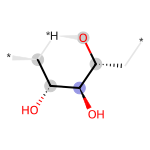

In [13]:
# bit collision
mol = Chem.MolFromSmiles('C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O')
bi = {}
fp = Chem.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
print(bi)
Draw.DrawMorganBit(mol, 1844, bi, useSVG=True)

{80: ((0, 0), (1, 0)), 251: ((2, 1),), 495: ((1, 1),), 728: ((2, 0),), 1109: ((3, 1),), 1456: ((0, 1),), 1683: ((3, 0),), 1844: ((0, 2),)}


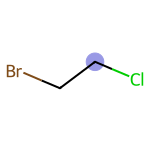

In [14]:
mol = Chem.MolFromSmiles('C(CBr)Cl')
bi = {}
fp = Chem.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
print(bi)
Draw.DrawMorganBit(mol, 1844, bi, useSVG=True)

# Figure 6

In [15]:
smiles_list = df_test.sort_values('freesolv').smiles.tolist()
y_pred, y_std, df_interpret= interpret_training_mols(
    smiles_list, 
    smiles_train, 
    targets_train, 
    alpha=alpha, 
    n_mol=n_mol, 
    output_order='sort_by_percentage_contribution', 
    mgk_hyperparameters_file='hyperopt-graph/hyperparameters_0.json',
    n_jobs=1)
for df in df_interpret:
    df['acc_contribution_percentage'] = np.cumsum(df.contribution_percentage)
y_pred, y_std, df_interpret_morgan= interpret_training_mols(
    smiles_list, 
    smiles_train, 
    targets_train, 
    alpha=alpha, 
    n_mol=n_mol, 
    output_order='sort_by_percentage_contribution', 
    mgk_hyperparameters_file=None,
    features_hyperparameters_file='hyperopt-morgan/features_hyperparameters.json',
    features_generator = ['morgan'],
    n_jobs=1)
for df in df_interpret_morgan:
    df['acc_contribution_percentage'] = np.cumsum(df.contribution_percentage)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    4.2s finished


<Figure size 1600x800 with 0 Axes>

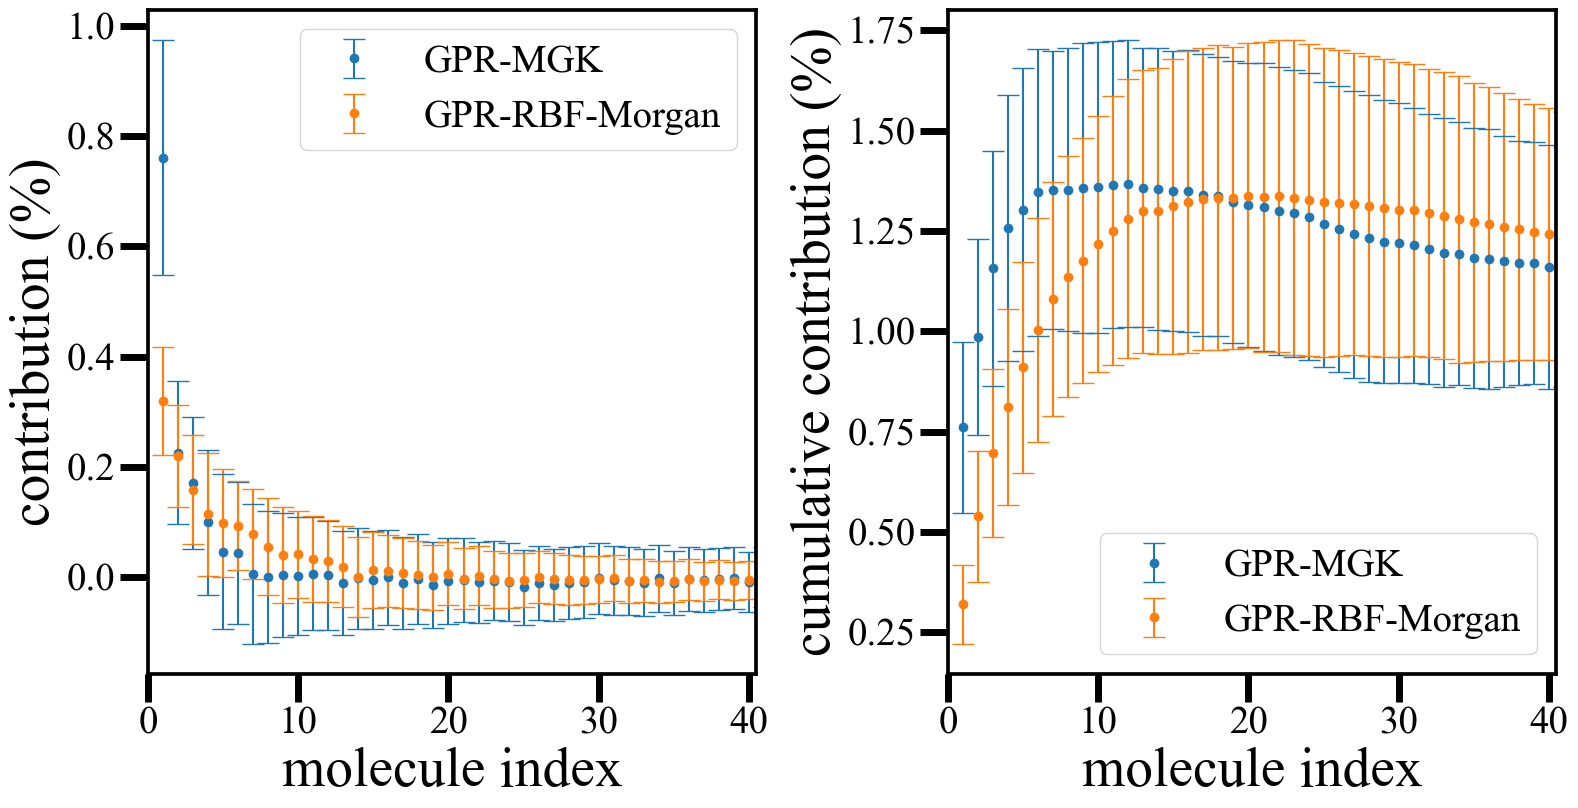

In [16]:
fs = 8
params = {'legend.fontsize': '%s' % (3.5 * fs),
          'figure.figsize': (fs * 2, fs * 1),  # 8*6
          'axes.labelsize': '%s' % (5 * fs),
          'axes.titlesize': '%s' % (5 * fs),
          'xtick.labelsize': '%s' % (3.5 * fs),
          'ytick.labelsize': '%s' % (3.5 * fs),
          'font.family': 'serif',
          'font.serif': 'Times New Roman',
          'axes.linewidth': fs / 3,
          }
pylab.rcParams.update(params)
fig = plt.figure()
fig.tight_layout()

fig = plt.figure()
fig.tight_layout()

dxs = [0.1, 0.12, 0.02]  # left to right
dx = (1 - sum(dxs)) / (len(dxs) - 1)
dys = [0.15, 0.02]  # down to top
dy = (1 - sum(dys)) / (len(dys) - 1)

nx = 1
ny = 1
ax = fig.add_axes(
    [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
ax.tick_params(width=5, length=20)
c_list = np.array([df.contribution_percentage.tolist() for df in df_interpret])
#c_list = abs(c_list)
x = df_interpret[0].index + 1
y = np.mean(c_list, axis=0)
y_err = np.std(c_list, axis=0)
ax.errorbar(x, y, yerr=y_err, fmt='o', capsize=8, label='GPR-MGK')
#ax.fill_between(x, y-y_err, y+y_err, color='k', alpha=0.5, )

c_list = np.array([df.contribution_percentage.tolist() for df in df_interpret_morgan])
#c_list = abs(c_list)
x = df_interpret[0].index + 1
y = np.mean(c_list, axis=0)
y_err = np.std(c_list, axis=0)
ax.errorbar(x, y, yerr=y_err, fmt='o', capsize=8, label='GPR-RBF-Morgan')

ax.set_xlim([0,40.5])
ax.set_xlabel('molecule index')
ax.set_ylabel('contribution (%)')

ax.legend()

nx = 2
ny = 1
ax = fig.add_axes(
    [sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
ax.tick_params(width=5, length=20)
c_list = np.array([df.contribution_percentage.tolist() for df in df_interpret])
c_list = np.cumsum(c_list, axis=1)
x = df_interpret[0].index + 1
y = np.mean(c_list, axis=0)
y_err = np.std(c_list, axis=0)
ax.errorbar(x, y, yerr=y_err, fmt='o', capsize=8, label='GPR-MGK')
#ax.fill_between(x, y-y_err, y+y_err, color='k', alpha=0.5, )

c_list = np.array([df.contribution_percentage.tolist() for df in df_interpret_morgan])
c_list = np.cumsum(c_list, axis=1)
x = df_interpret[0].index + 1
y = np.mean(c_list, axis=0)
y_err = np.std(c_list, axis=0)
ax.errorbar(x, y, yerr=y_err, fmt='o', capsize=8, label='GPR-RBF-Morgan')

ax.set_xlim([0,40.5])
ax.set_xlabel('molecule index')
ax.set_ylabel('cumulative contribution (%)')
ax.legend()

plt.savefig('figure6.png')